In [1]:
import numpy as np
import pandas as pd
import math 
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.preprocessing import PolynomialFeatures
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 50)

## data loading and prep

In [2]:
data = pd.read_csv('datasets/coins project/neo_full.csv')

In [3]:
zero_cleaner_features =['twitterFollowers','redditSubscribers','forks', 'stars',
       'subscribers', 'totalIssues', 'closedIssues','pullRequestContributors', 'additionsIn4Week', 'deletionIn4Week',
       'commitCount4Weeks']
features =['price', 'volume', 'marketCap', 'twitterFollowers',
       'redditAveragePosts48h', 'redditAverageComments48h',
       'redditSubscribers', 'redditAccountsActive48h',
        'alexaRank', 'forks', 'stars',
       'subscribers', 'totalIssues', 'closedIssues',
       'pullRequestContributors', 'additionsIn4Week', 'deletionIn4Week',
       'commitCount4Weeks']
targets = ['price_in_1_day', 'price_in_2_day',
       'price_in_3_day', 'price_in_4_day', 'price_in_5_day', 'price_in_6_day',
       'price_in_7_day', 'price_in_8_day', 'price_in_9_day', 'price_in_10_day',
       'grow_in_1_day', 'grow_in_2_day', 'grow_in_3_day', 'grow_in_4_day',
       'grow_in_5_day', 'grow_in_6_day', 'grow_in_7_day', 'grow_in_8_day',
       'grow_in_9_day', 'grow_in_10_day']

def zero_cleaner(column):
    up =0
    for i in range(len(column)):
        val = column[i]
        if column[i] == 0 and up ==0 and i >=1:
            up = column[i-1]
        if column[i] != 0 and up!=0:
            j=i
            ave = (column[i]+up)/2
            while j>=1 and column[j-1] ==0:
                column[j-1] = ave
                j-=1
            up = 0

def target_generator(data):
    b = data['price']
    for in_days in range(1,11):
        target = 'price_in_{}_day'.format(in_days)
        data[target] = data['price']
        a = data[target]
        for i in range(len(b)):
            if i<len(b)-in_days:
                a[i] = b[i+in_days]
            else:
                a[i] = b[i-5:i].mean()

def grow_label_generator(data):
    b = data['price']
    for in_days in range(1,11):
        target = 'grow_in_{}_day'.format(in_days)
        data[target] = data['price']
        a = data[target]
        for i in range(len(b)):
            if i<len(b)-in_days:
                if a[i] < b[i+in_days]:
                    a[i] = 1
                else:
                    a[i] = 0
            else:
                a[i]=-1   
                
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_rmse(y_true, y_pred): 
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(y_true)-np.array(y_pred))**2))

def plot_trend(true_trend,pred_trend = [], split_point=0,full_x=False):
    plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(true_trend,'blue',label = "true values",alpha=0.6)
    if len(pred_trend) >0:
        plt.plot(pred_trend,'red',label ='prediction',alpha=0.6)
    plt.legend(loc="upper left")
    if full_x ==True:
        plt.xticks(range(len(true_trend)))
        plt.grid(True)
    if split_point !=0:
        plt.axvline(x=split_point,linewidth=2.5)
    plt.show()
    
def bank(cast, true):
    bank = 100
    coin = 0

    for i, elm in enumerate(cast):
        if i == cast.shape[0]-1:
            continue
        diff = cast[i+1]-cast[i]
        true_diff = true[i+1]-true[i]
        if diff < 0 and coin != 0:
            bank+=coin - true[i]
            coin = 0
        if diff>0 and coin==0:
            coin = true[i]

    return bank

In [4]:
for feature in zero_cleaner_features:
    zero_cleaner(data[feature])
target_generator(data)                
grow_label_generator(data)
data.head()

name                   date      price     volume   marketCap  \
0  neo  2017-09-02 00:00:00.0  30.763900   49637713  1538194980   
1  neo  2017-09-03 00:00:00.0  30.957925   21438821  1547896236   
2  neo  2017-09-04 00:00:00.0  23.023138  143111765  1151156917   
3  neo  2017-09-05 00:00:00.0  23.674946   53125834  1183747315   
4  neo  2017-09-06 00:00:00.0  21.515456   46065917  1075772788   

   twitterFollowers  redditAveragePosts48h  redditAverageComments48h  \
0             65687                      3                       136   
1             66436                      3                       123   
2             67419                      3                       127   
3             68640                      3                       171   
4             70173                      2                       165   

   redditSubscribers  redditAccountsActive48h  telegramChanelUserCount  \
0              22013                      703                        0   
1              22277                      580                        0   
2              22821                      963                        0   
3              23713                     1309                        0   
4              24351                     1097                        0   

   alexaRank  bingMatches  forks  stars  subscribers  totalIssues  \
0      39974            0    279    799          208           39   
1      39580            0    281    805          209           39   
2      39065            0    281    809          209           39   
3      38513            0    282    812          209           39   
4      37837            0    284    816          210           40   

   closedIssues  pullRequestsMerged  pullRequestContributors  \
0            32                   0                       10   
1            32                   0                       10   
2            32                   0                       10   
3            32                   0                       10   
4            33                   0                       10   

   additionsIn4Week  deletionIn4Week  commitCount4Weeks  price_in_1_day  \
0                 0                0                 19       30.957925   
1                 0                0                 19       23.023138   
2                 0                0                 19       23.674946   
3                 0                0                 20       21.515456   
4                 0                0                 20       30.842616   

   price_in_2_day  price_in_3_day  price_in_4_day  price_in_5_day  \
0       23.023138       23.674946       21.515456       30.842616   
1       23.674946       21.515456       30.842616       25.753812   
2       21.515456       30.842616       25.753812       22.050382   
3       30.842616       25.753812       22.050382       23.210249   
4       25.753812       22.050382       23.210249       21.672536   

   price_in_6_day  price_in_7_day  price_in_8_day  price_in_9_day  \
0       25.753812       22.050382       23.210249       21.672536   
1       22.050382       23.210249       21.672536       20.868057   
2       23.210249       21.672536       20.868057       20.143343   
3       21.672536       20.868057       20.143343       15.095051   
4       20.868057       20.143343       15.095051       18.174860   

   price_in_10_day  grow_in_1_day  grow_in_2_day  grow_in_3_day  \
0        20.868057            1.0            0.0            0.0   
1        20.143343            0.0            0.0            0.0   
2        15.095051            1.0            0.0            1.0   
3        18.174860            0.0            1.0            1.0   
4        20.133571            1.0            1.0            1.0   

   grow_in_4_day  grow_in_5_day  grow_in_6_day  grow_in_7_day  grow_in_8_day  \
0            0.0            1.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0 

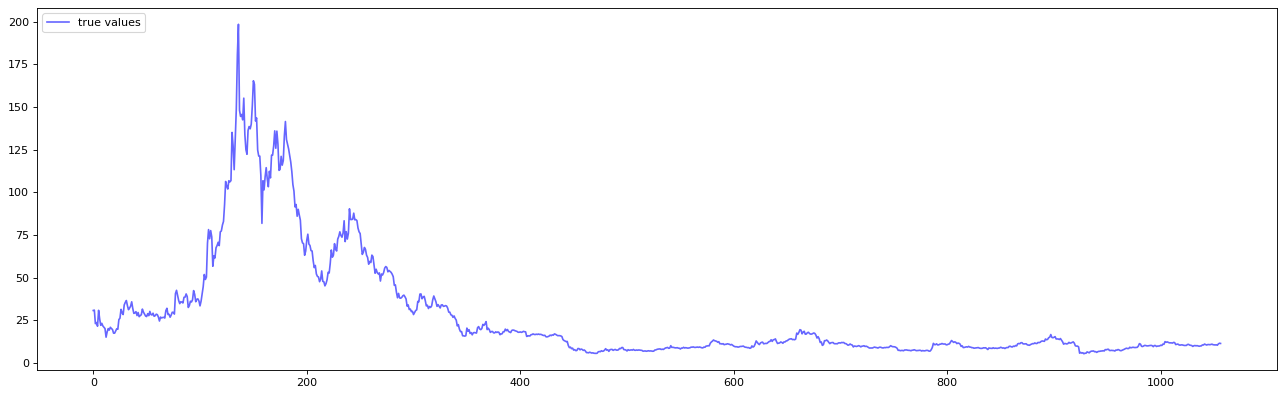

NameError: name 'y' is not defined

In [5]:
plot_trend(data['price'])
plot_trend(y['price'])

# Modeling

In [6]:
data.shape

(1057, 43)

In [7]:
def last_value_base_model(data ,point_a, N, plot = True):
    pred = []

    X_train = data[point_a-N:point_a][features]
    y_train = data[point_a-N:point_a][targets] 
    X_test = data[point_a:point_a+1][features]
    y_test = data[point_a:point_a+10]['price'].values
    
    pred =data[point_a:point_a+10]['price_in_1_day'].values
    
    if plot:
        plot_trend(y_test , pred,full_x=True)
        print('rmse:\t',get_rmse(y_test , pred))
        print('mape:\t',get_mape(y_test , pred))
    return pred , get_rmse(y_test , pred) ,get_mape(y_test , pred)

In [8]:
def multi_reg_model(data ,point_a , N, plot = True, forcast =False):
    pred = []

    X_train = data[point_a-N:point_a][features]
    y_train = data[point_a-N:point_a][targets] 
    X_test = data[point_a:point_a+1][features]
    if forcast==False:
        y_test = data[point_a:point_a+10]['price'].values
    for i in range(1,11):
        reg = LinearRegression().fit(X_train, y_train['price_in_{}_day'.format(i)])
        pred.append(reg.predict(X_test)[0])
    
    if plot:
        if forcast==True:
            plot_trend(pred,full_x=True)
            return pred
        else:
            temp_y_test = np.insert(y_test, 0, data[point_a-1:point_a]['price'].values, axis=0)
            temp_pred = np.insert(pred, 0, data[point_a-1:point_a]['price'].values, axis=0)
            plot_trend(temp_y_test , temp_pred,full_x=True)
            print('rmse:\t',get_rmse(y_test , pred))
            print('mape:\t',get_mape(y_test , pred))
    try:
        return pred , get_rmse(y_test , pred) ,get_mape(y_test , pred)
    except:
        return pred

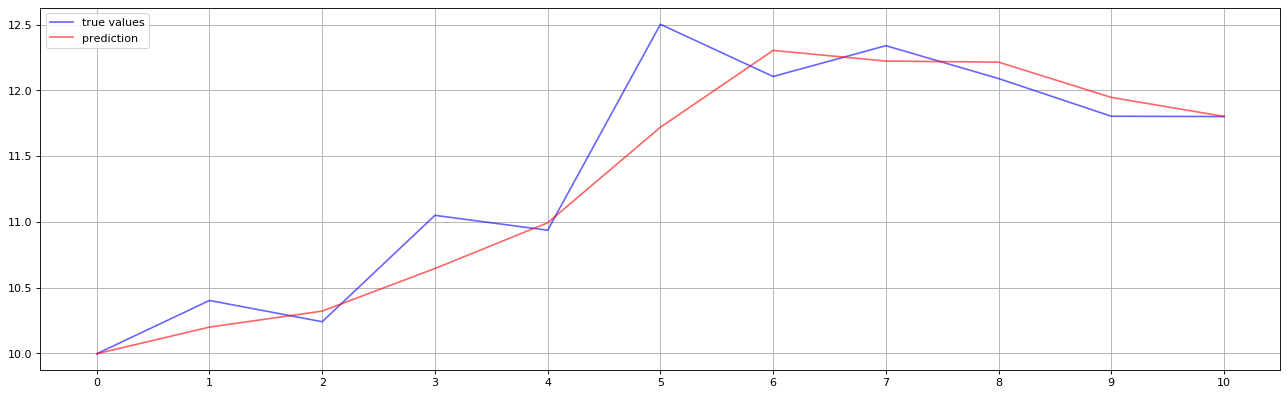

rmse:	 0.30279972885513506
mape:	 1.8025361422134005


([10.19994643780318,
  10.321681460592906,
  10.645591519984277,
  10.993490202945761,
  11.720337566185123,
  12.304815420296649,
  12.223512333982264,
  12.21557230692643,
  11.94723005715232,
  11.802652131699627],
 0.30279972885513506,
 1.8025361422134005)

In [9]:
multi_reg_model(data ,1000 , 2, plot = True)

## base line model 

In [10]:
N =10
rmse_sum =0
mape_sum =0
for i in range(N,data.shape[0]-10):
    pred , rmse , mape = last_value_base_model(data , i, N=N ,plot = False)
    rmse_sum+=rmse
    mape_sum+=mape
l=len(range(N,data.shape[0]-10))
print('\trmse:{}\tmape:{}'.format(rmse_sum/l,mape_sum/l))

	rmse:1.9624437788292795	mape:4.414020504161777


## tune

In [11]:
for N in range(2,20):
    rmse_sum =0
    mape_sum =0
    for i in range(N,data.shape[0]-10):
        pred , rmse , mape = multi_reg_model(data , i, N=N ,plot = False)
        rmse_sum+=rmse
        mape_sum+=mape
    l=len(range(N,data.shape[0]-10))
    print('N:{}\trmse:{}\tmape:{}'.format(N,rmse_sum/l,mape_sum/l))

N:2	rmse:3.917089725794134	mape:7.582990753686216
N:3	rmse:9.904990088552529	mape:26.752328806549567
N:4	rmse:7.241456406473866	mape:19.043432707693757
N:5	rmse:7.432632906298694	mape:20.708121681582085
N:6	rmse:10.028997146161279	mape:25.39895860542546
N:7	rmse:15.200642859944097	mape:37.957867984021
N:8	rmse:13.967392907124113	mape:43.60583934314134
N:9	rmse:11.255262055965082	mape:39.14564538974761
N:10	rmse:10.958285640885206	mape:43.306211346449764
N:11	rmse:10.42151748280139	mape:38.34998740143554
N:12	rmse:10.065940029918922	mape:35.59876991498972
N:13	rmse:11.45890659366893	mape:45.38839325471461
N:14	rmse:14.327046073004878	mape:52.71073105239884
N:15	rmse:37.200073400787694	mape:116.60054738982092
N:16	rmse:1464.614217234084	mape:6825.49991348443
N:17	rmse:37.169458581540354	mape:270.8142364360823
N:18	rmse:23.461841834515727	mape:151.61557705989566
N:19	rmse:24.650059799934322	mape:153.59443080132309


whole optima N =2 

N:2	rmse:1.4667759372198588	mape:1.9046174403247347
N:3	rmse:0.8171970599963392	mape:0.9989827751723291
N:4	rmse:0.8714169918669497	mape:1.1703639363379963
N:5	rmse:12.649914055473086	mape:16.677792093271258
N:6	rmse:13.123001422056406	mape:17.41809423390673
N:7	rmse:12.479945718392116	mape:15.22282054491004
N:8	rmse:13.889724392922904	mape:17.15338267231617
N:9	rmse:8.239808088093369	mape:11.45269901631914
N:10	rmse:8.777776688102039	mape:12.272537890667254
N:11	rmse:7.861616946198473	mape:9.17321162714558
N:12	rmse:11.78249961174511	mape:15.13481447215353
N:13	rmse:17.4265223109807	mape:23.293437260378454
N:14	rmse:26.58027129140887	mape:36.918025398767625


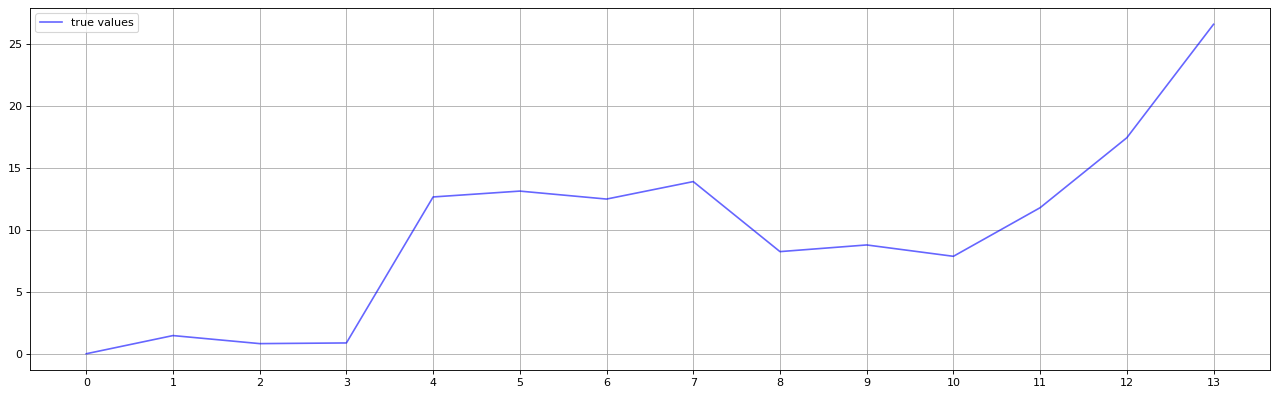

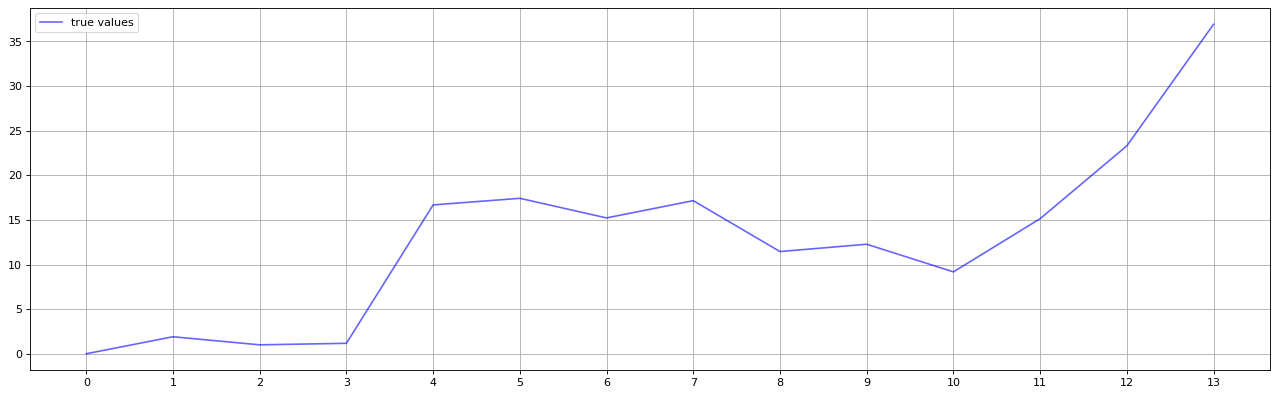

In [12]:
rmse_arr = [0]
mape_arr = [0]
for i in range (2,15):
    pred , rmse , mape = multi_reg_model(data , 250, i,False)
    rmse_arr.append(rmse)
    mape_arr.append(mape)
    print('N:{}\trmse:{}\tmape:{}'.format(i , rmse,mape))
plot_trend(rmse_arr,full_x=True)
plot_trend(mape_arr,full_x=True)

# forcast dashboard

N:2	rmse:1.1342234057043579	mape:1.9585431930646076
N:3	rmse:11.06568337578576	mape:20.22611908827753
N:4	rmse:13.250777250424825	mape:30.45760217660634
N:5	rmse:10.693444358940932	mape:30.478885964271257
N:6	rmse:14.603220934982723	mape:35.89210901811216
N:7	rmse:12.52428606881463	mape:30.51160295766216
N:8	rmse:9.695990193458776	mape:23.55691185565883
N:9	rmse:15.537348228500871	mape:40.383724345965874
N:10	rmse:22.808219735364027	mape:57.897041907617066
N:11	rmse:17.35128731130016	mape:44.209625854942495
N:12	rmse:17.51372894051459	mape:43.052751475480484
N:13	rmse:19.382184854383983	mape:49.118892528954326
N:14	rmse:16.93470529882542	mape:43.83416427476366
N:15	rmse:53.65172774142033	mape:159.12227518881505
N:16	rmse:13.71013577035559	mape:37.03171669720902
N:17	rmse:46.406277262139376	mape:135.53786018910066
N:18	rmse:15.56258906620697	mape:39.96034627687427
N:19	rmse:8.375116542916263	mape:21.184430093473345
N:20	rmse:8.31949171385529	mape:21.117208884268273
N:21	rmse:8.325952773

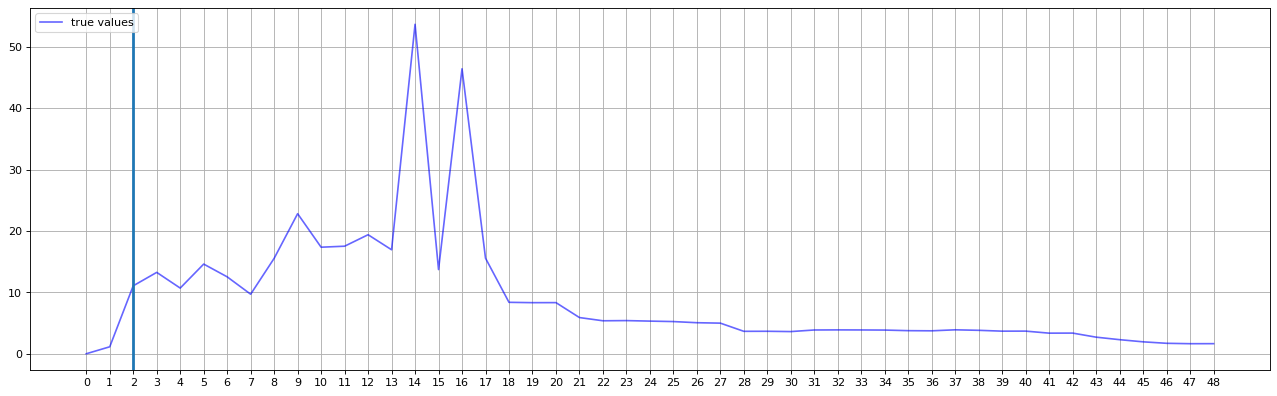

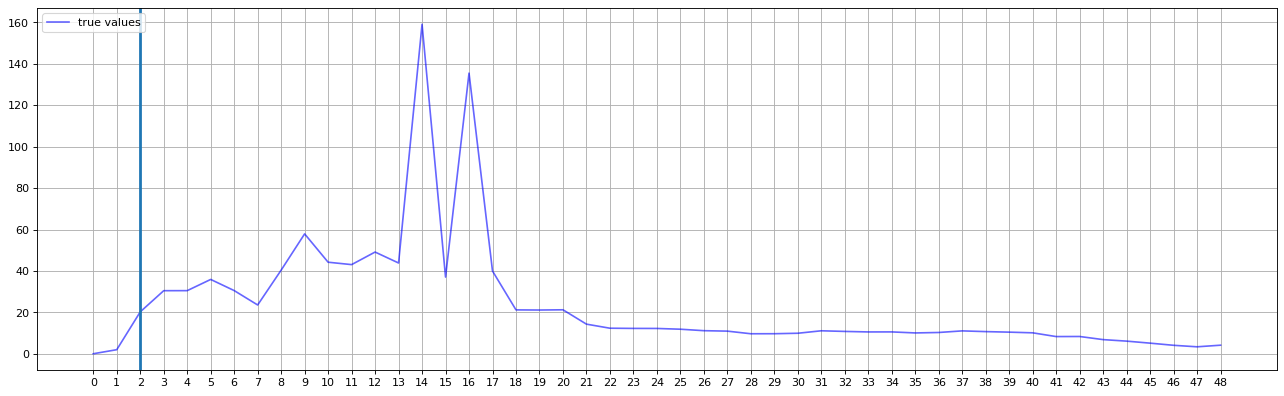

today forcast 2


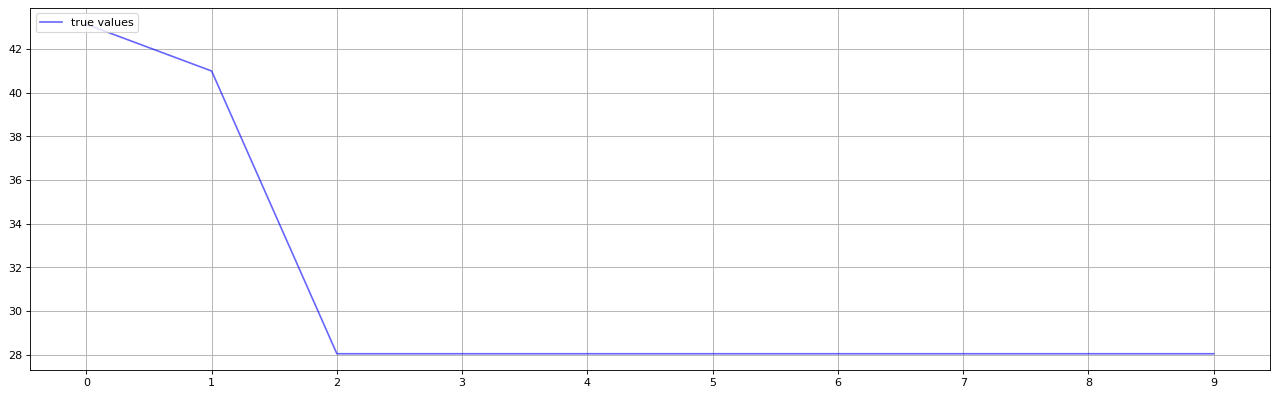

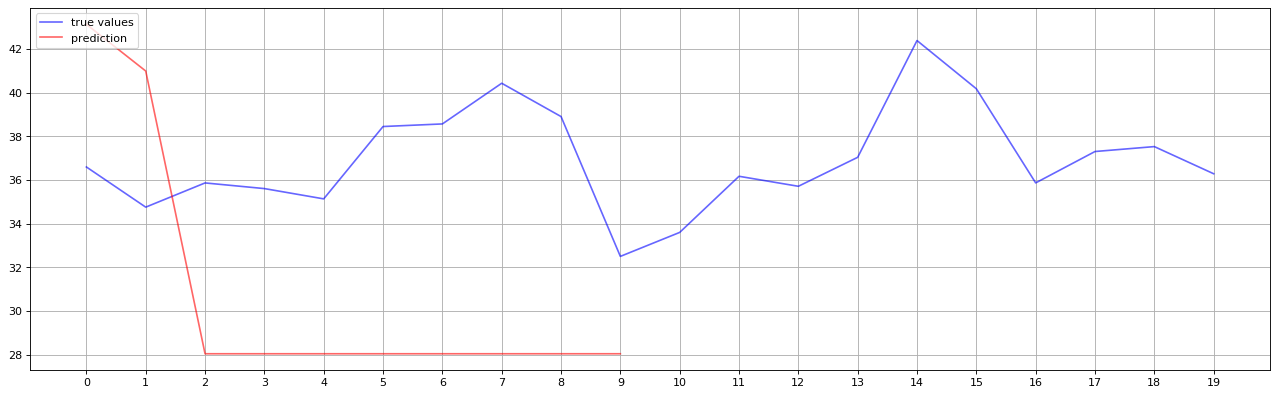

today forcast 2


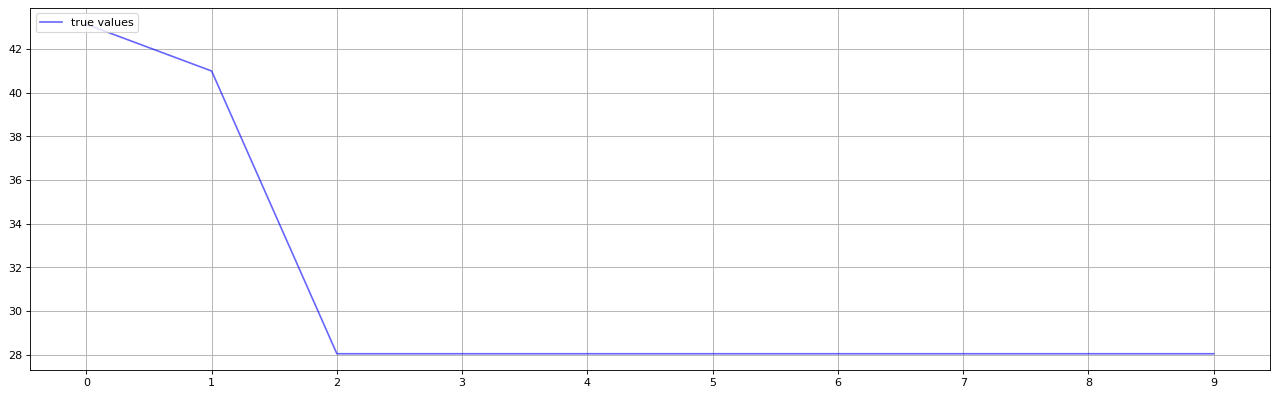

today forcast 2


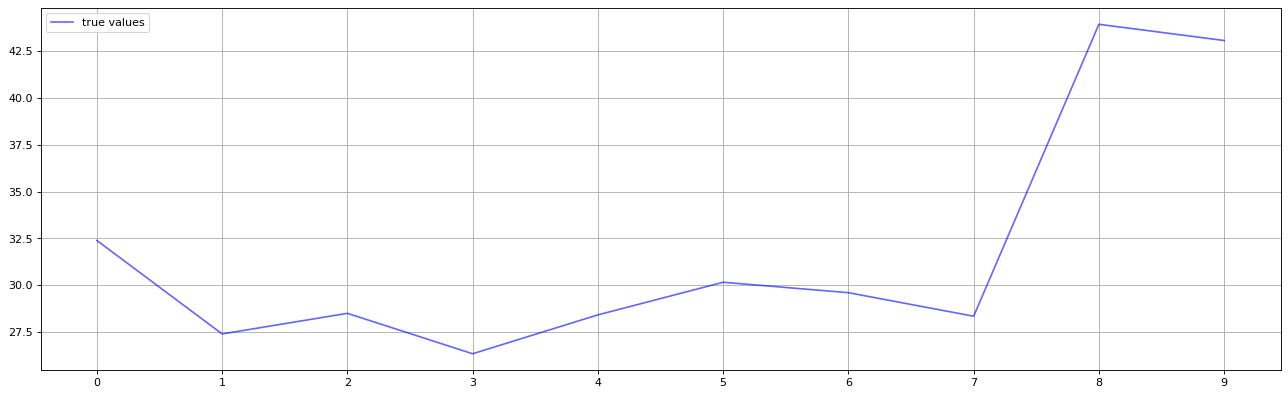

today forcast 2


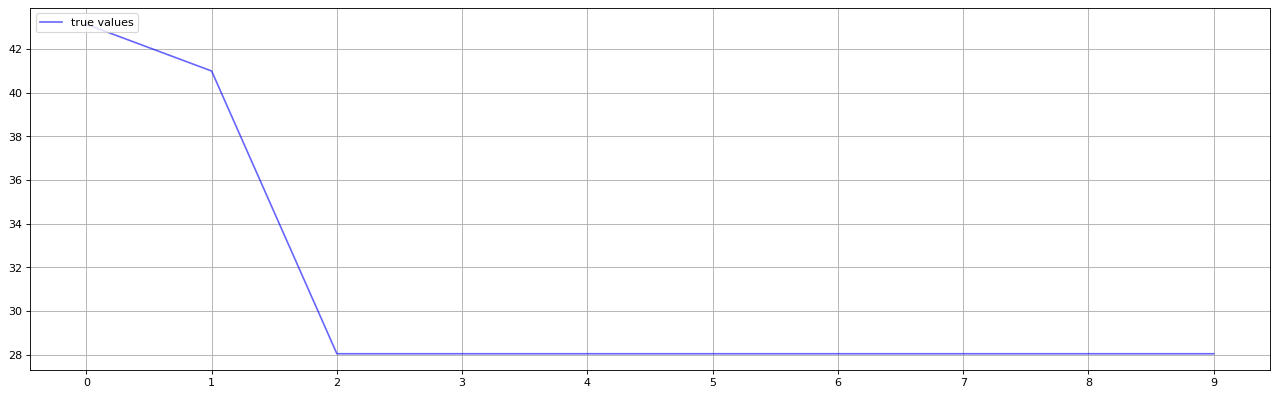

In [152]:
today = data.shape[0]-1

rmse_arr = [0]
mape_arr = [0]
opt_n =0
min_rmse =10000
for i in range (2,50):
    pred , rmse , mape = multi_reg_model(data , today-10, i,False)
    rmse_arr.append(rmse)
    mape_arr.append(mape)
    if min_rmse > rmse:
        min_rmse = rmse
        opt_n=i
    print('N:{}\trmse:{}\tmape:{}'.format(i , rmse,mape))
plot_trend(rmse_arr,split_point = opt_n,full_x=True)
plot_trend(mape_arr,split_point = opt_n, full_x=True)

print('today forcast {}'.format(opt_n))
pred = multi_reg_model(data ,today , opt_n, plot = True,forcast=True)
print('today forcast 2')
multi_reg_model(data ,today , 2, plot = True,forcast=True)
print('today forcast {}'.format(opt_n))
multi_reg_model(data ,today-10 , opt_n, plot = True,forcast=True)
print('today forcast 2')
multi_reg_model(data ,today , 2, plot = True,forcast=True)

# Simulation

In [230]:
temp_data = pd.read_csv('datasets/coins project/neo_full.csv')
for feature in zero_cleaner_features:
    zero_cleaner(temp_data[feature])
target_generator(temp_data)                
grow_label_generator(temp_data)
temp_data.head()

name                   date      price     volume   marketCap  \
0  neo  2017-09-02 00:00:00.0  30.763900   49637713  1538194980   
1  neo  2017-09-03 00:00:00.0  30.957925   21438821  1547896236   
2  neo  2017-09-04 00:00:00.0  23.023138  143111765  1151156917   
3  neo  2017-09-05 00:00:00.0  23.674946   53125834  1183747315   
4  neo  2017-09-06 00:00:00.0  21.515456   46065917  1075772788   

   twitterFollowers  redditAveragePosts48h  redditAverageComments48h  \
0             65687                      3                       136   
1             66436                      3                       123   
2             67419                      3                       127   
3             68640                      3                       171   
4             70173                      2                       165   

   redditSubscribers  redditAccountsActive48h  telegramChanelUserCount  \
0              22013                      703                        0   
1              22277                      580                        0   
2              22821                      963                        0   
3              23713                     1309                        0   
4              24351                     1097                        0   

   alexaRank  bingMatches  forks  stars  subscribers  totalIssues  \
0      39974            0    279    799          208           39   
1      39580            0    281    805          209           39   
2      39065            0    281    809          209           39   
3      38513            0    282    812          209           39   
4      37837            0    284    816          210           40   

   closedIssues  pullRequestsMerged  pullRequestContributors  \
0            32                   0                       10   
1            32                   0                       10   
2            32                   0                       10   
3            32                   0                       10   
4            33                   0                       10   

   additionsIn4Week  deletionIn4Week  commitCount4Weeks  price_in_1_day  \
0                 0                0                 19       30.957925   
1                 0                0                 19       23.023138   
2                 0                0                 19       23.674946   
3                 0                0                 20       21.515456   
4                 0                0                 20       30.842616   

   price_in_2_day  price_in_3_day  price_in_4_day  price_in_5_day  \
0       23.023138       23.674946       21.515456       30.842616   
1       23.674946       21.515456       30.842616       25.753812   
2       21.515456       30.842616       25.753812       22.050382   
3       30.842616       25.753812       22.050382       23.210249   
4       25.753812       22.050382       23.210249       21.672536   

   price_in_6_day  price_in_7_day  price_in_8_day  price_in_9_day  \
0       25.753812       22.050382       23.210249       21.672536   
1       22.050382       23.210249       21.672536       20.868057   
2       23.210249       21.672536       20.868057       20.143343   
3       21.672536       20.868057       20.143343       15.095051   
4       20.868057       20.143343       15.095051       18.174860   

   price_in_10_day  grow_in_1_day  grow_in_2_day  grow_in_3_day  \
0        20.868057            1.0            0.0            0.0   
1        20.143343            0.0            0.0            0.0   
2        15.095051            1.0            0.0            1.0   
3        18.174860            0.0            1.0            1.0   
4        20.133571            1.0            1.0            1.0   

   grow_in_4_day  grow_in_5_day  grow_in_6_day  grow_in_7_day  grow_in_8_day  \
0            0.0            1.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0 

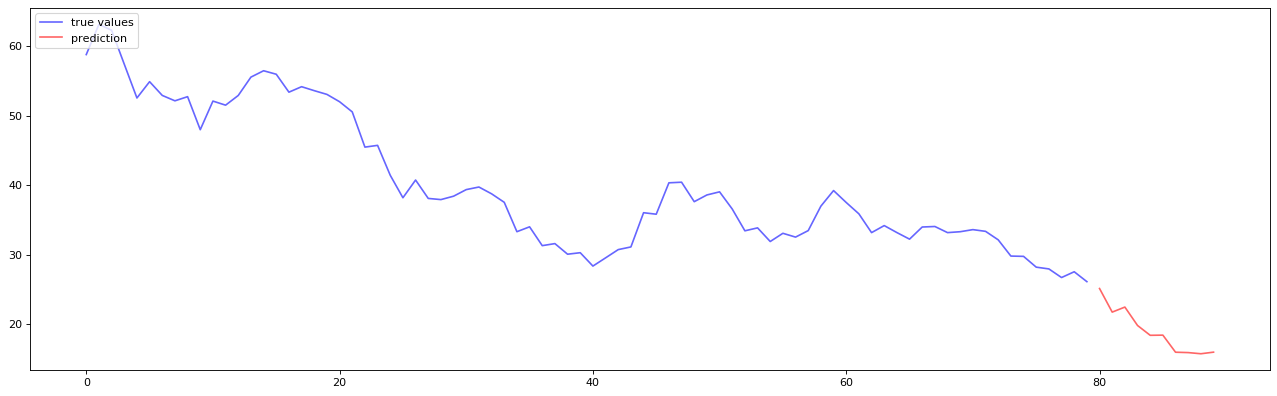

last price:26.104766054310872	next price:25.11767989981502
today forcast 2


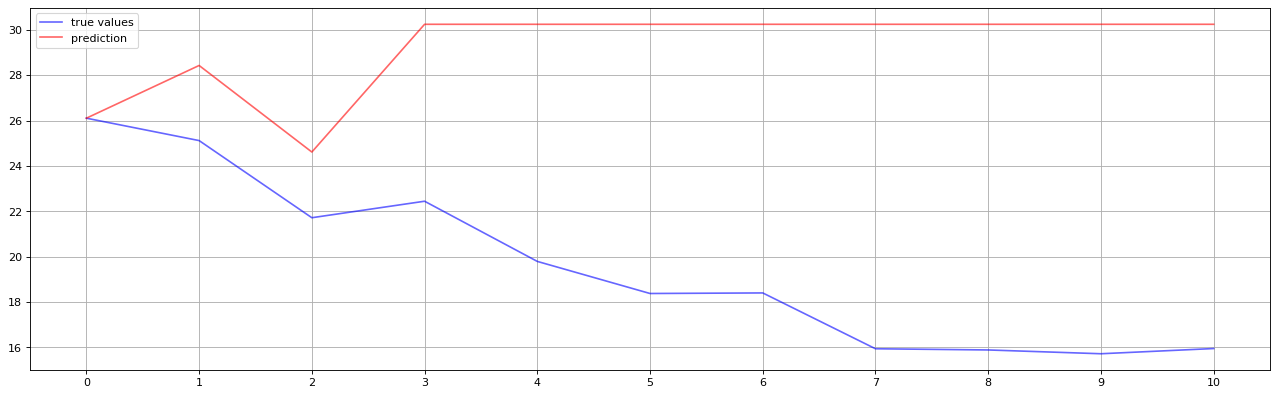

today forcast 2


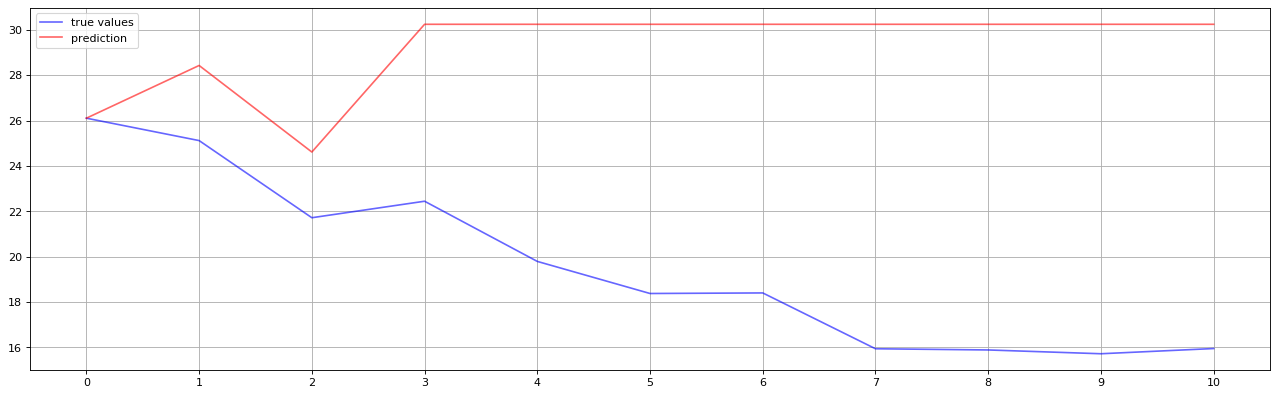

[28.42761747803744, 24.61342966844471, 30.2425002954101, 30.2425002954101, 30.2425002954101, 30.2425002954101, 30.2425002954101, 30.2425002954101, 30.2425002954101, 30.2425002954101]


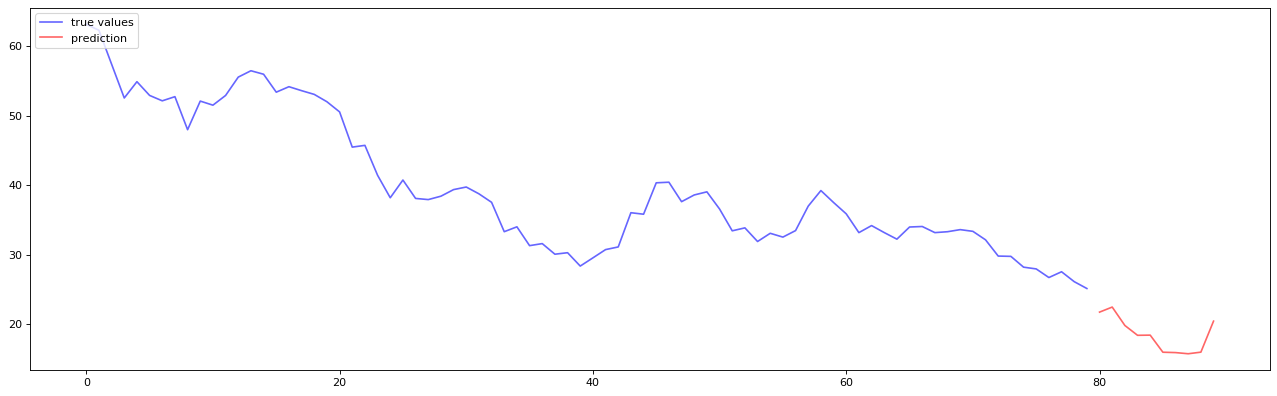

last price:25.11767989981502	next price:21.7182671594696
today forcast 3


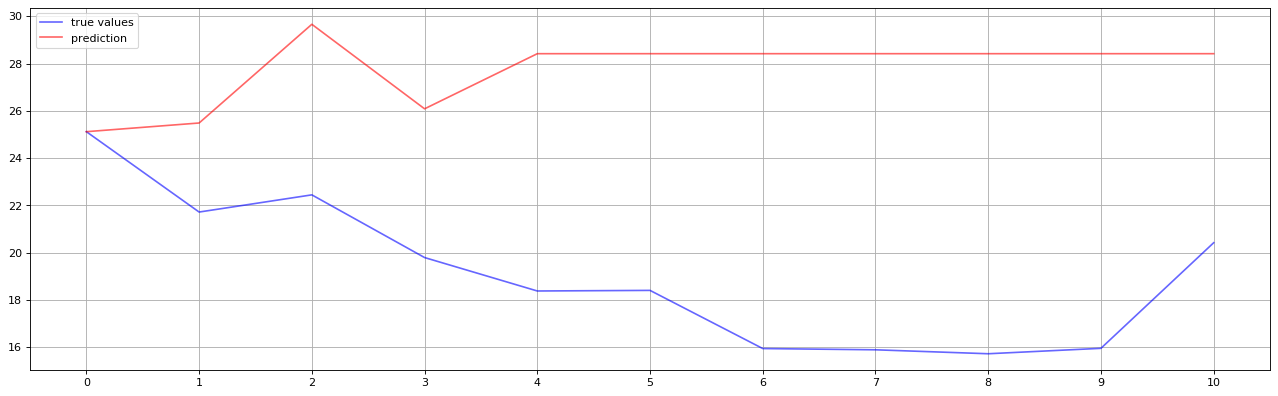

today forcast 2


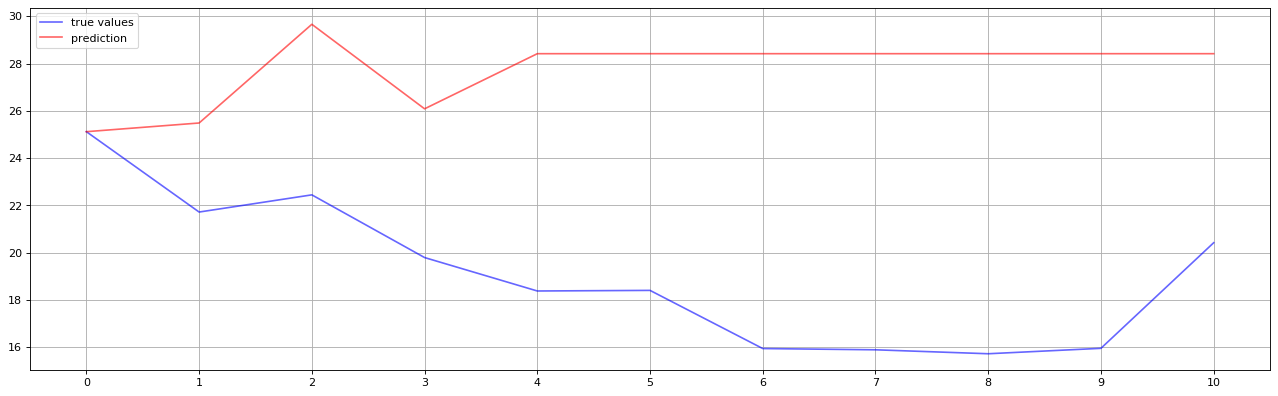

[24.427491478583477, 30.051820608029878, 27.705508277930445, 27.705508277930445, 27.705508277930445, 27.705508277930445, 27.705508277930445, 27.705508277930445, 27.705508277930445, 27.705508277930445]


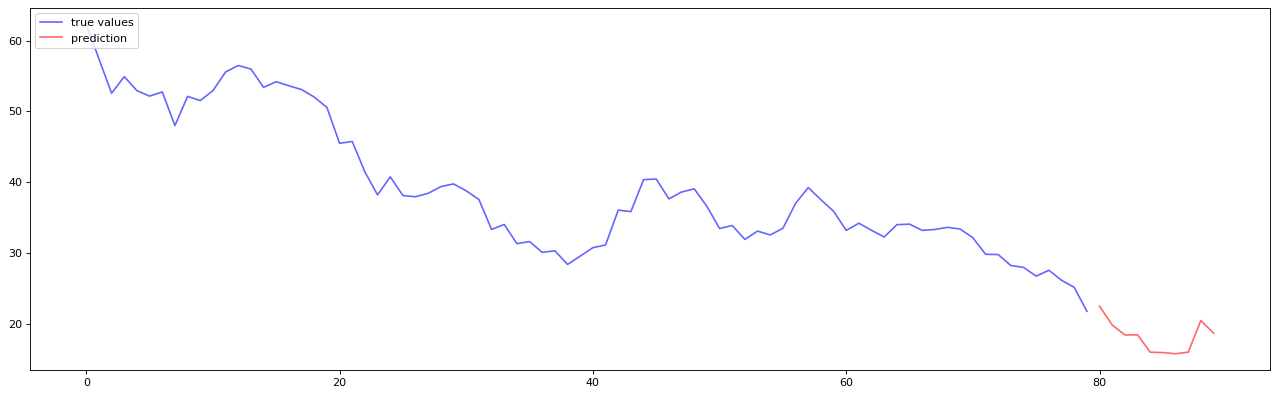

last price:21.7182671594696	next price:22.44507175902153
today forcast 6


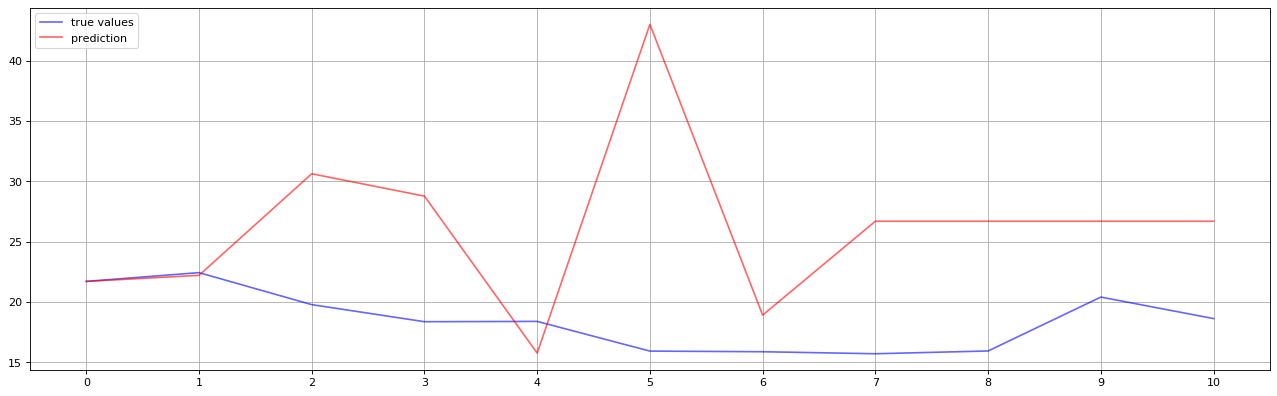

today forcast 2


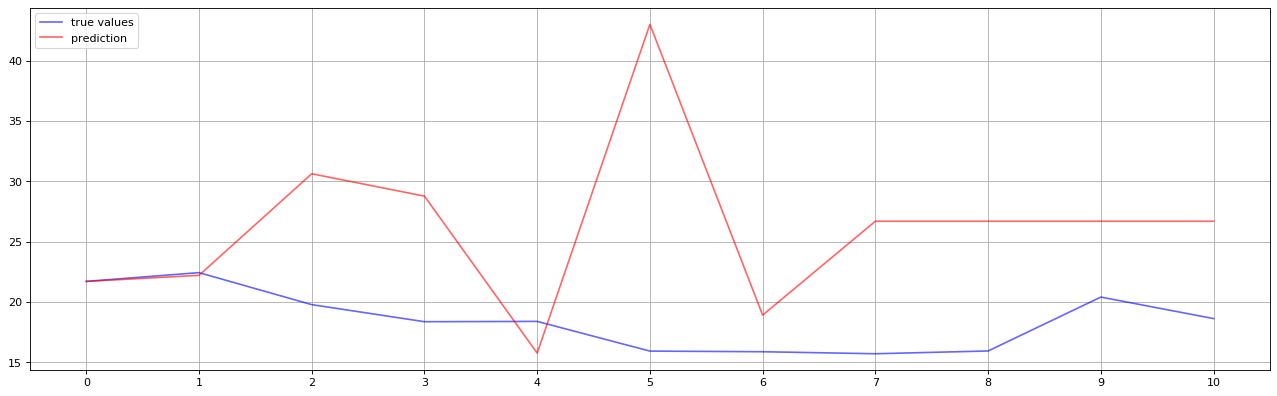

[10.453047568688447, 45.7817430052682, 24.972698782584104, 24.972698782584104, 24.972698782584104, 24.972698782584104, 24.972698782584104, 24.972698782584104, 24.972698782584104, 24.972698782584104]


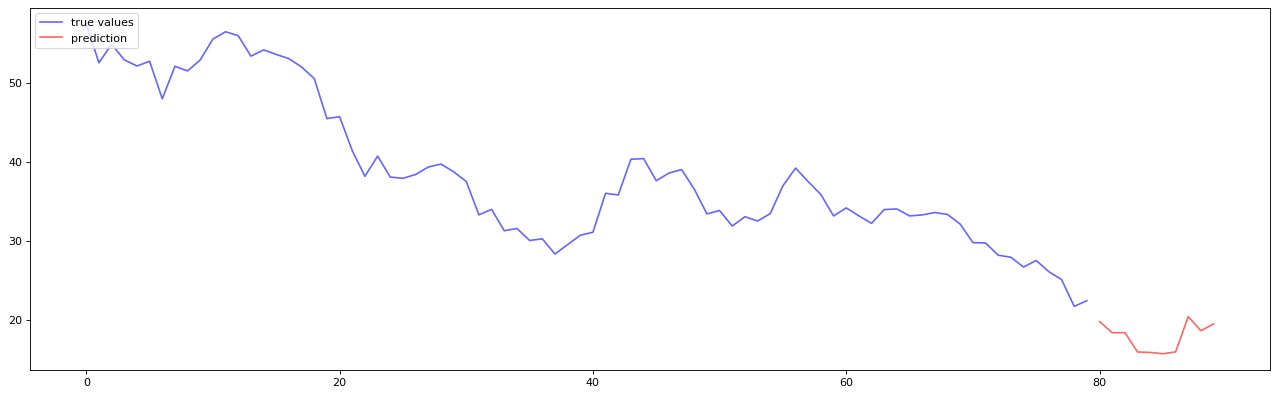

last price:22.44507175902153	next price:19.79291318535069
today forcast 27


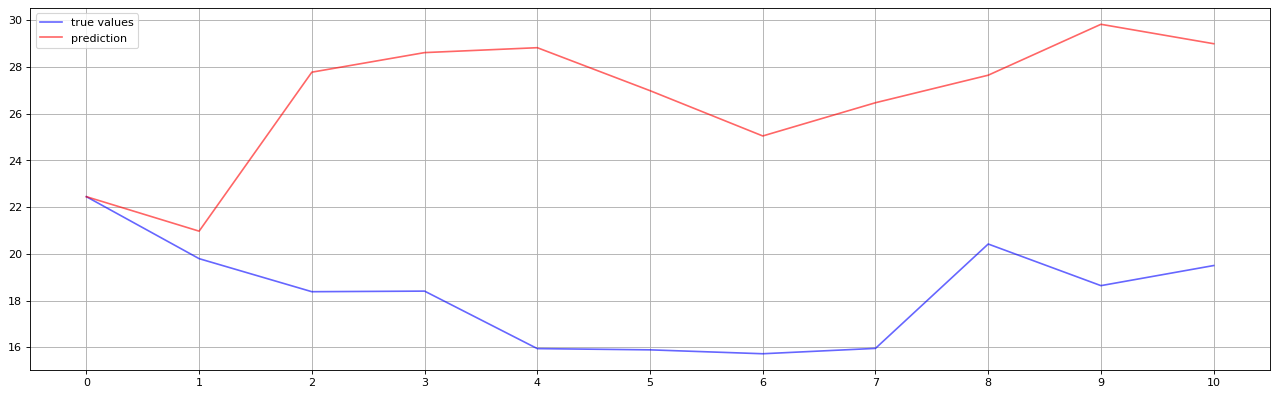

today forcast 2


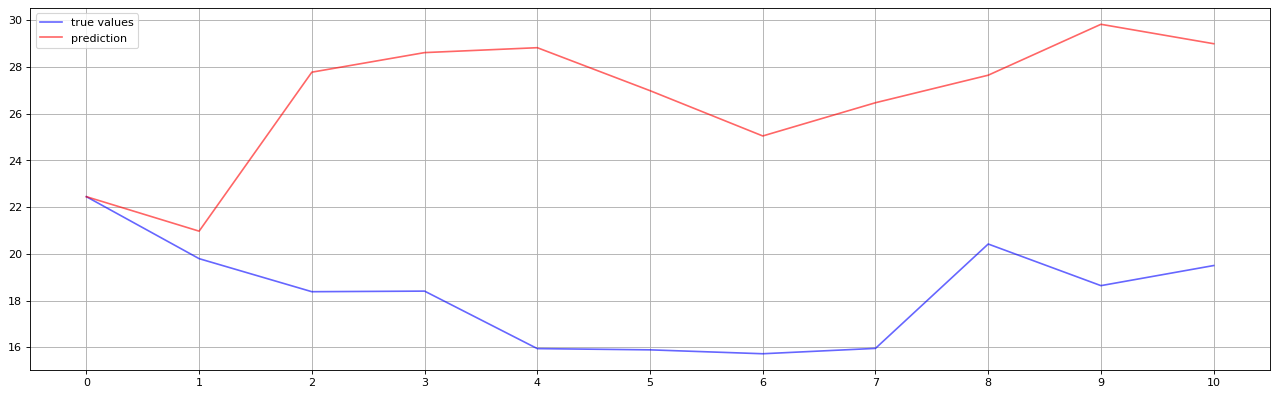

[22.287418345904463, 25.759720897533487, 26.811303432105404, 26.811303432105404, 26.811303432105404, 26.811303432105404, 26.811303432105404, 26.811303432105404, 26.811303432105404, 26.811303432105404]


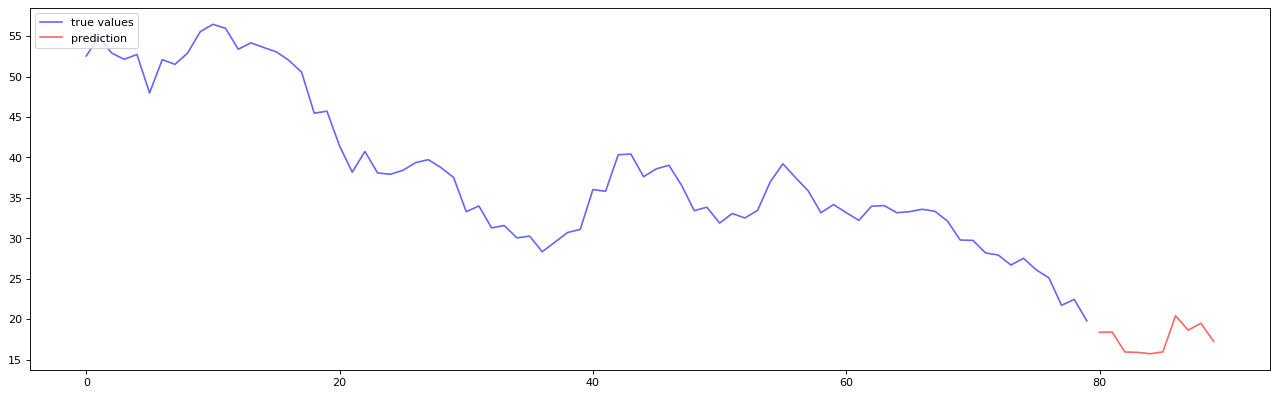

last price:19.79291318535069	next price:18.378746004666148
today forcast 28


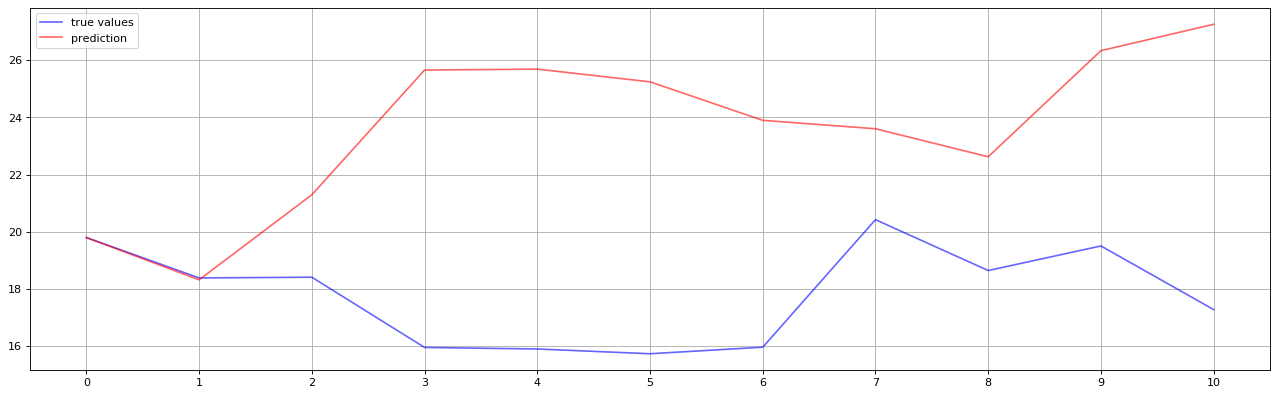

today forcast 2


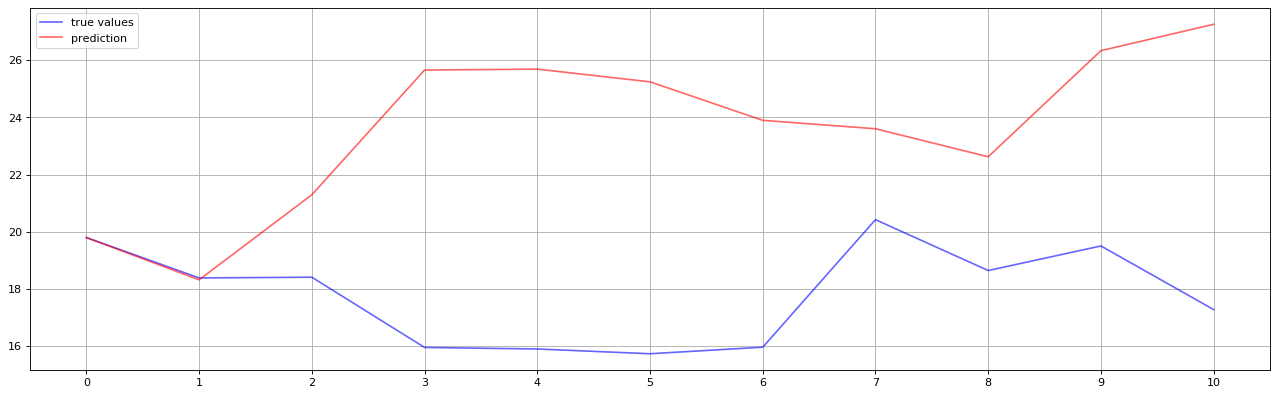

[27.227223704551136, 9.621743975817225, 28.92108326585738, 28.92108326585738, 28.92108326585738, 28.92108326585738, 28.92108326585738, 28.92108326585738, 28.92108326585738, 28.92108326585738]


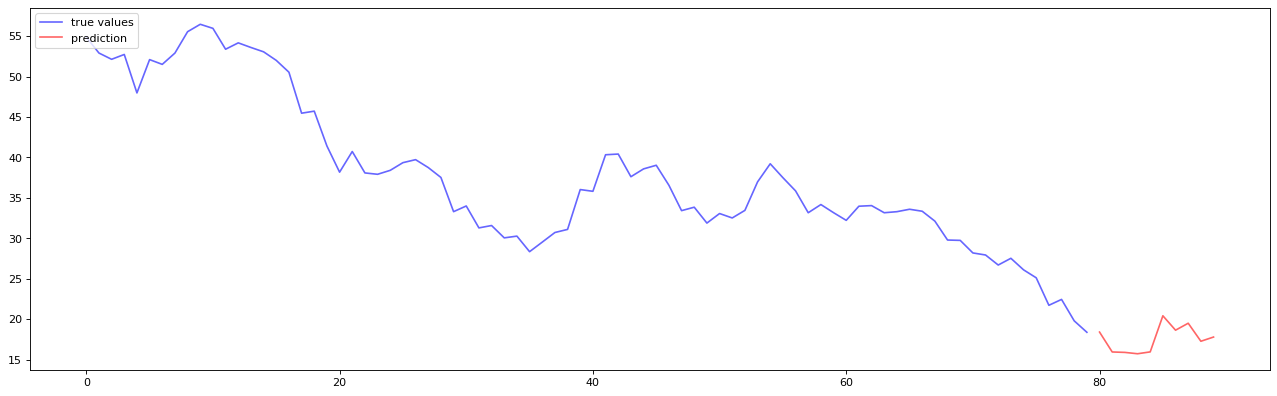

last price:18.378746004666148	next price:18.403851401222287
today forcast 2


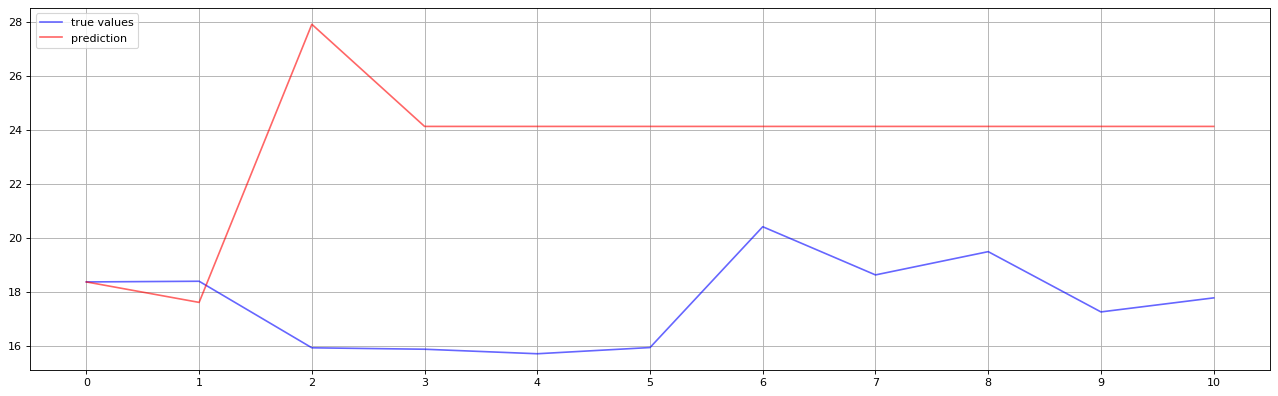

today forcast 2


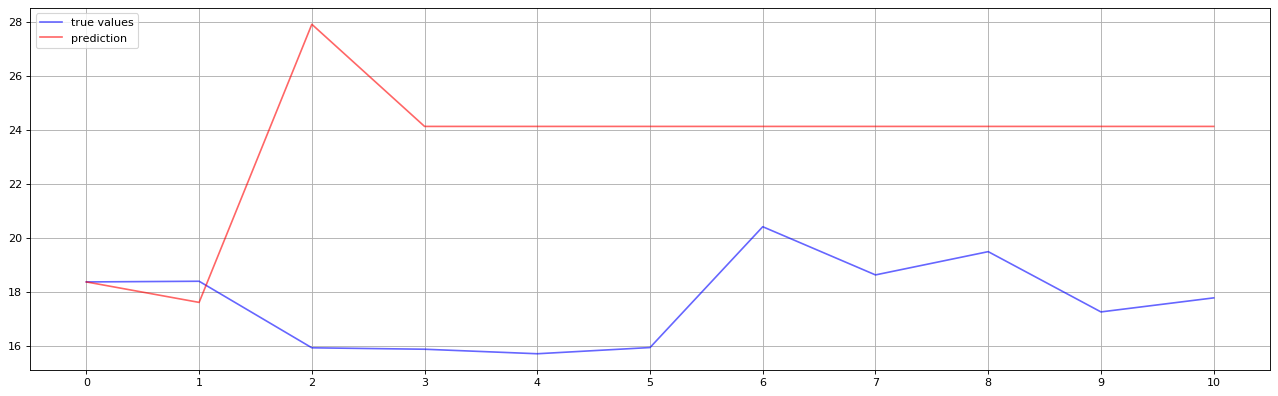

[17.621970317135464, 27.903420567367327, 24.127990352244677, 24.127990352244677, 24.127990352244677, 24.127990352244677, 24.127990352244677, 24.127990352244677, 24.127990352244677, 24.127990352244677]


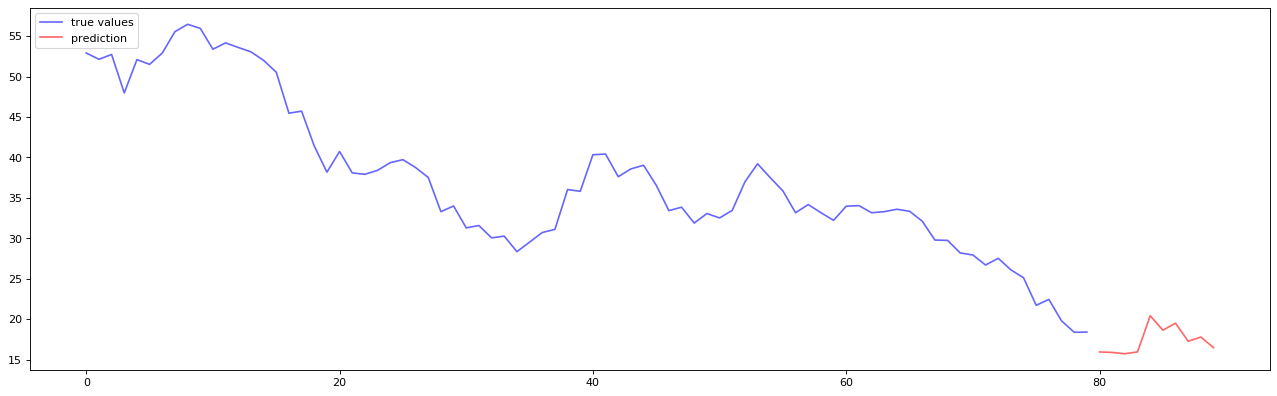

last price:18.403851401222287	next price:15.943717053490953
today forcast 22


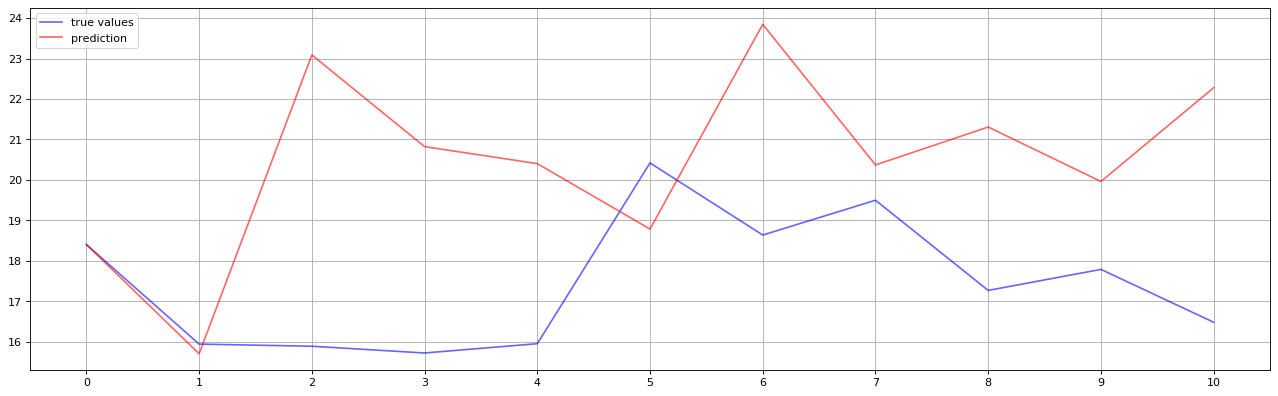

today forcast 2


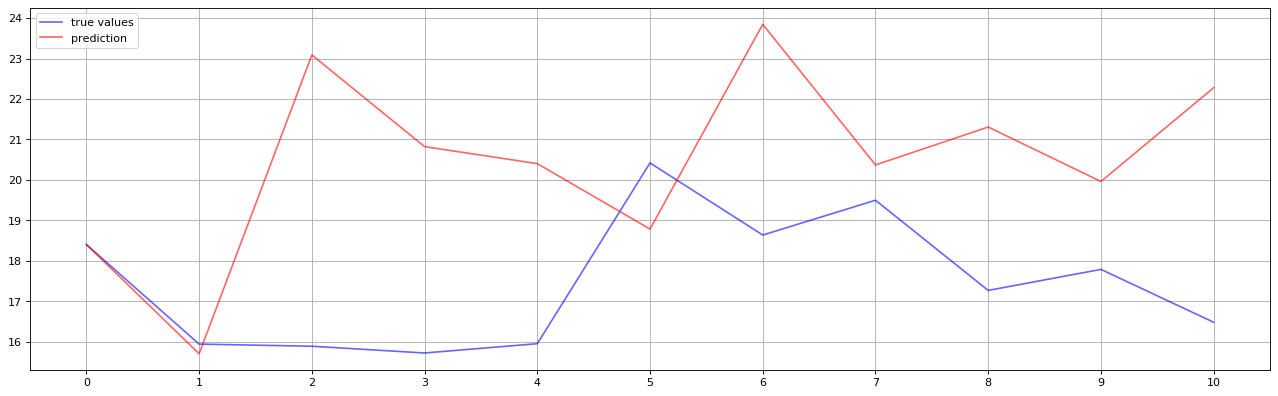

[18.399355055843976, 22.20617417927764, 23.312885126719067, 23.312885126719067, 23.312885126719067, 23.312885126719067, 23.312885126719067, 23.312885126719067, 23.312885126719067, 23.312885126719067]


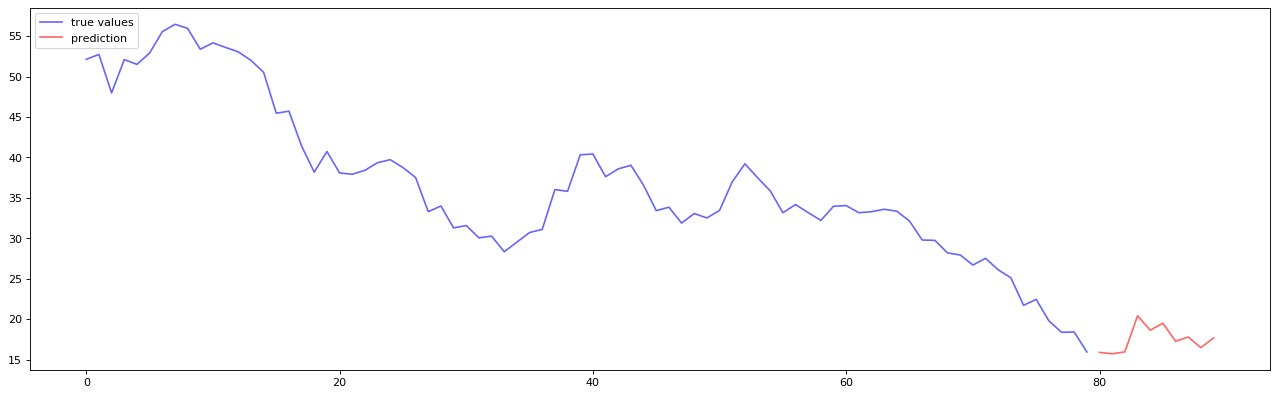

last price:15.943717053490953	next price:15.890660830195309
today forcast 2


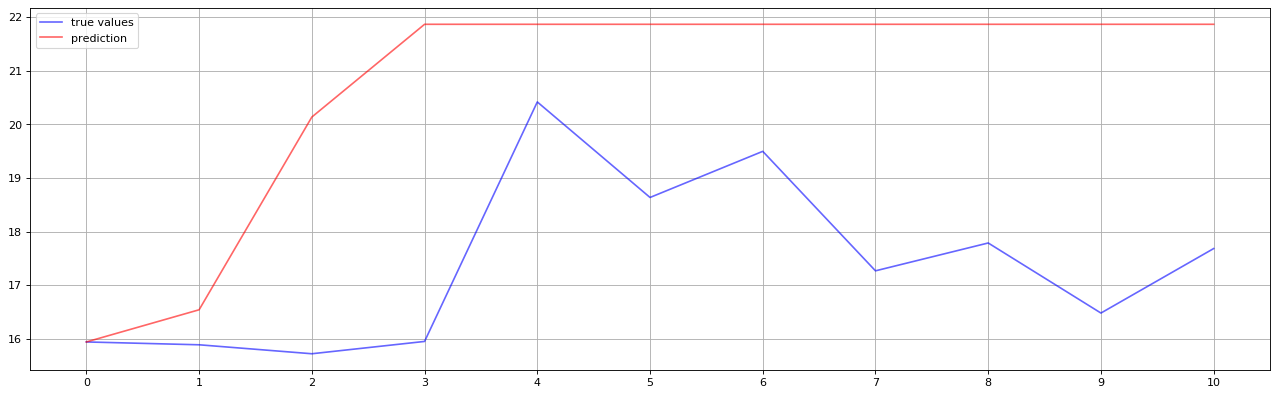

today forcast 2


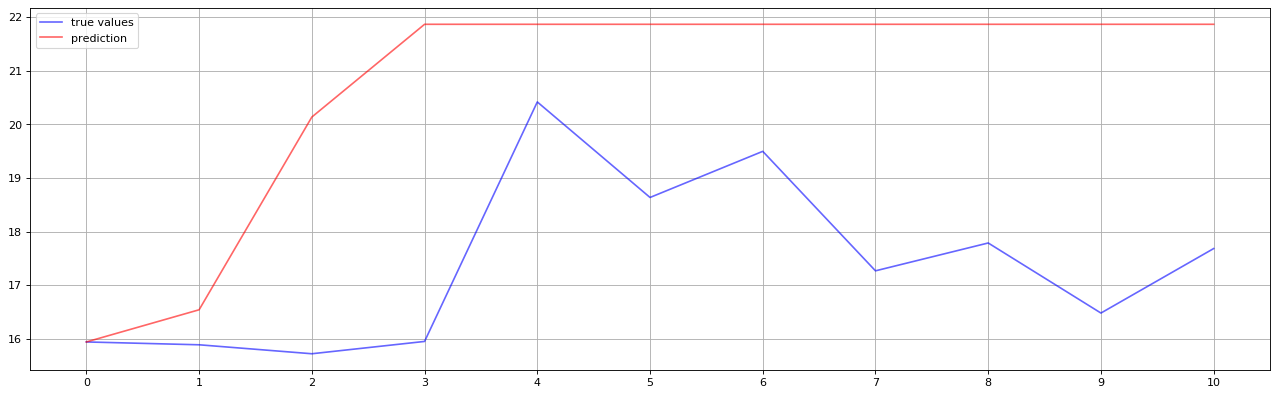

[16.543683909461393, 20.137801638962454, 21.86737322946525, 21.86737322946525, 21.86737322946525, 21.86737322946525, 21.86737322946525, 21.86737322946525, 21.86737322946525, 21.86737322946525]


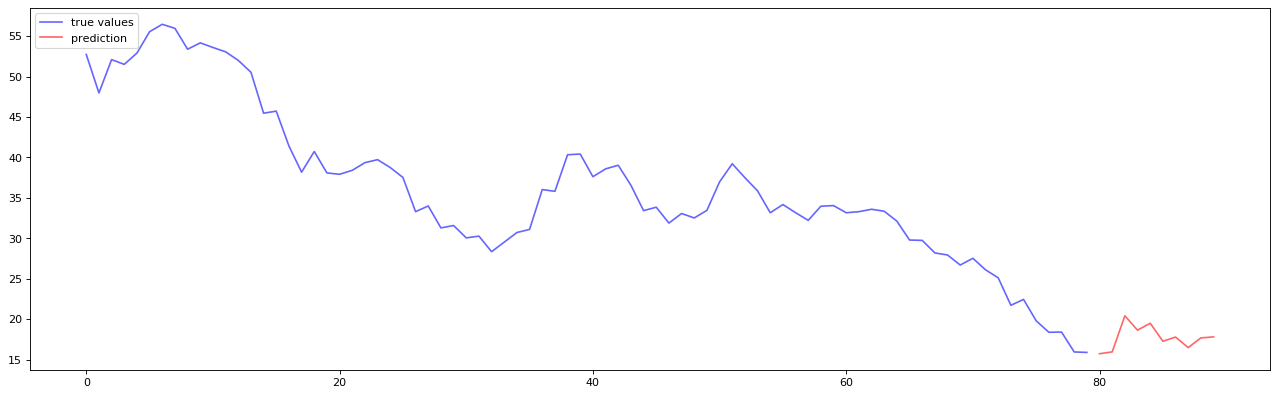

last price:15.890660830195309	next price:15.723570851997582
today forcast 49


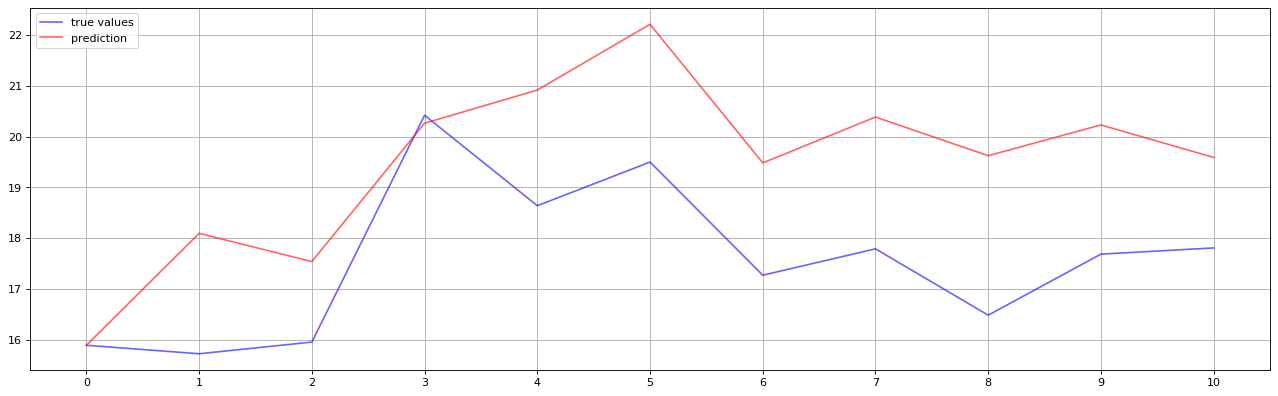

today forcast 2


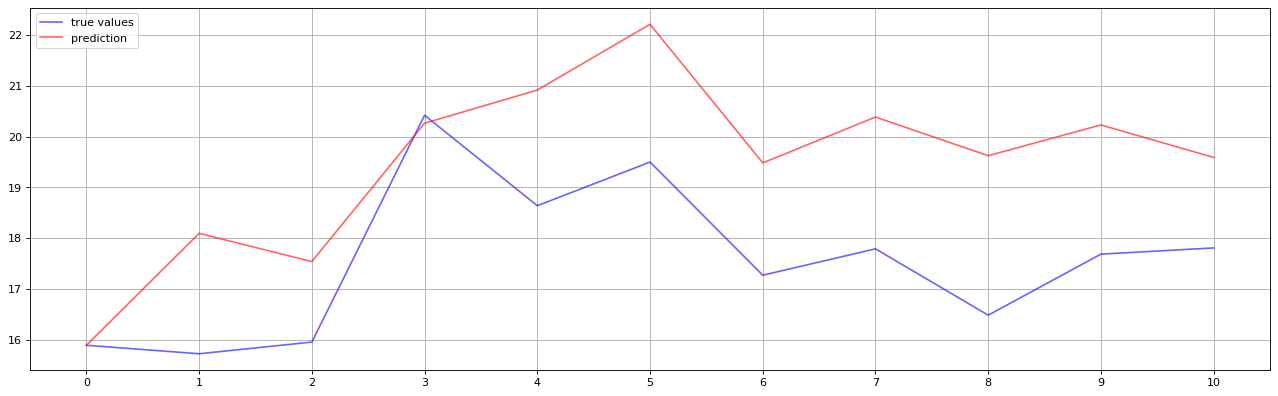

[15.888985085318259, 20.282227808576117, 20.10535955679496, 20.10535955679496, 20.10535955679496, 20.10535955679496, 20.10535955679496, 20.10535955679496, 20.10535955679496, 20.10535955679496]


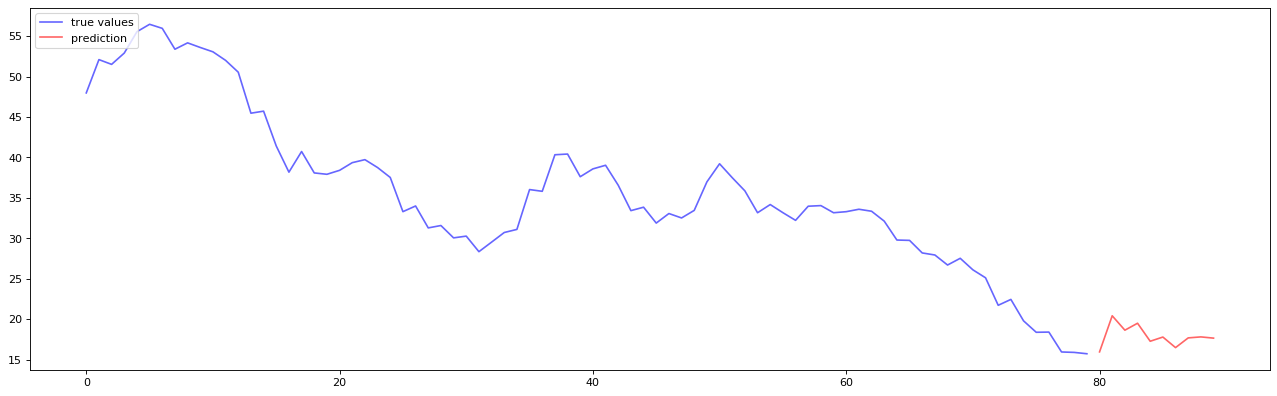

last price:15.723570851997582	next price:15.953277977444069
today forcast 2


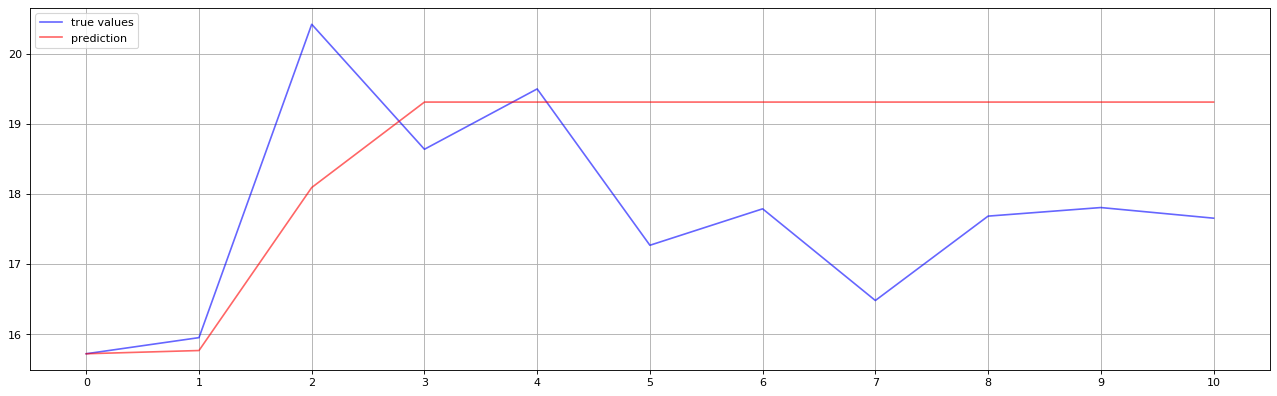

today forcast 2


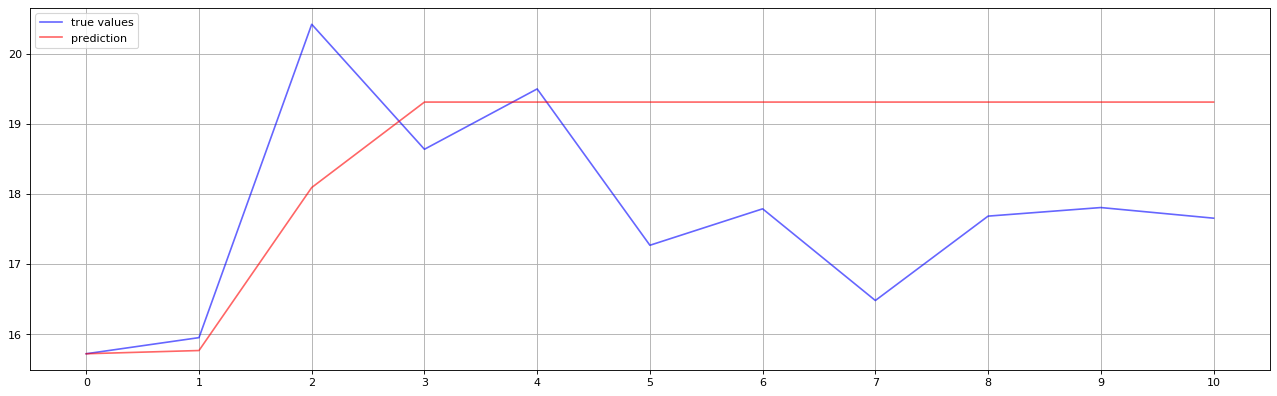

[15.769570421161047, 18.09283051683773, 19.31080452333509, 19.31080452333509, 19.31080452333509, 19.31080452333509, 19.31080452333509, 19.31080452333509, 19.31080452333509, 19.31080452333509]


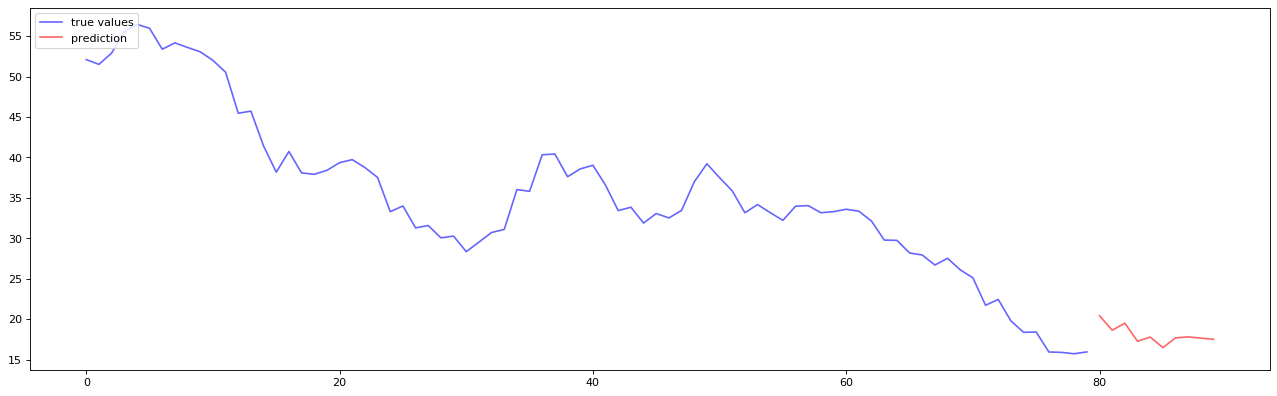

last price:15.953277977444069	next price:20.419382672112995
today forcast 3


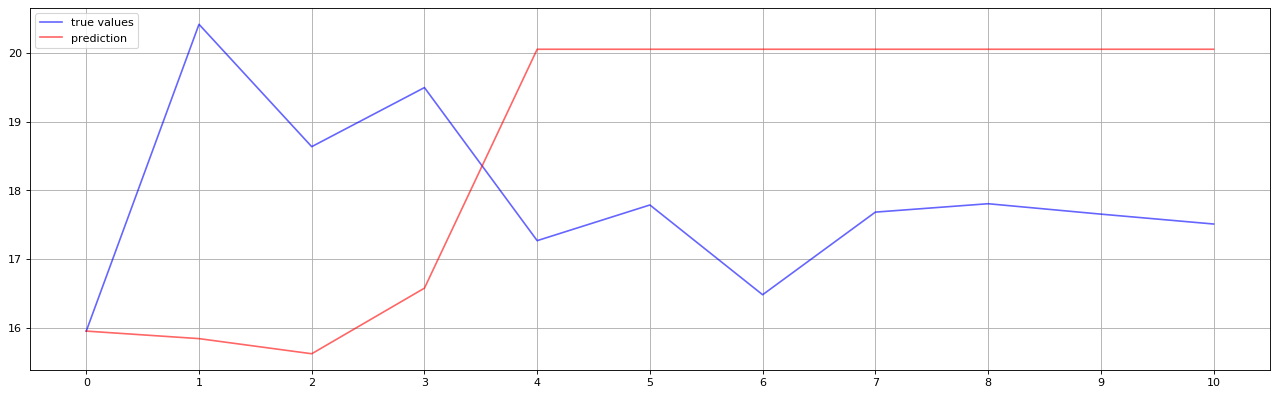

today forcast 2


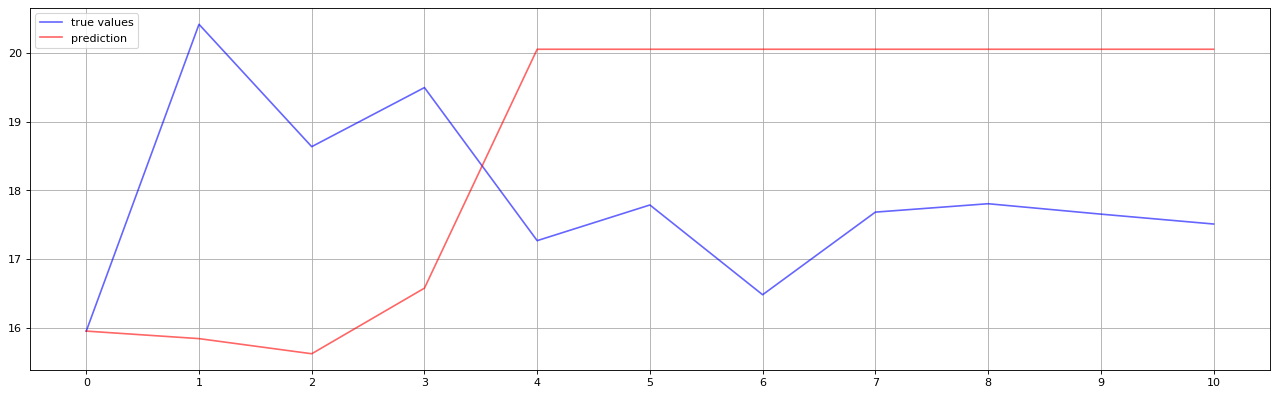

[16.05958647072044, 18.48202019232538, 17.075301216139838, 17.075301216139838, 17.075301216139838, 17.075301216139838, 17.075301216139838, 17.075301216139838, 17.075301216139838, 17.075301216139838]


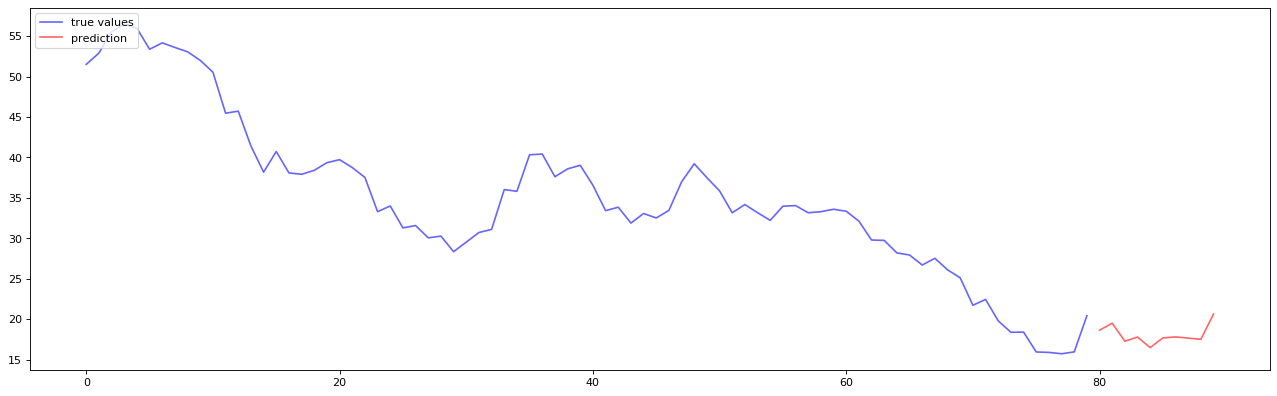

last price:20.419382672112995	next price:18.6380973513821
today forcast 3


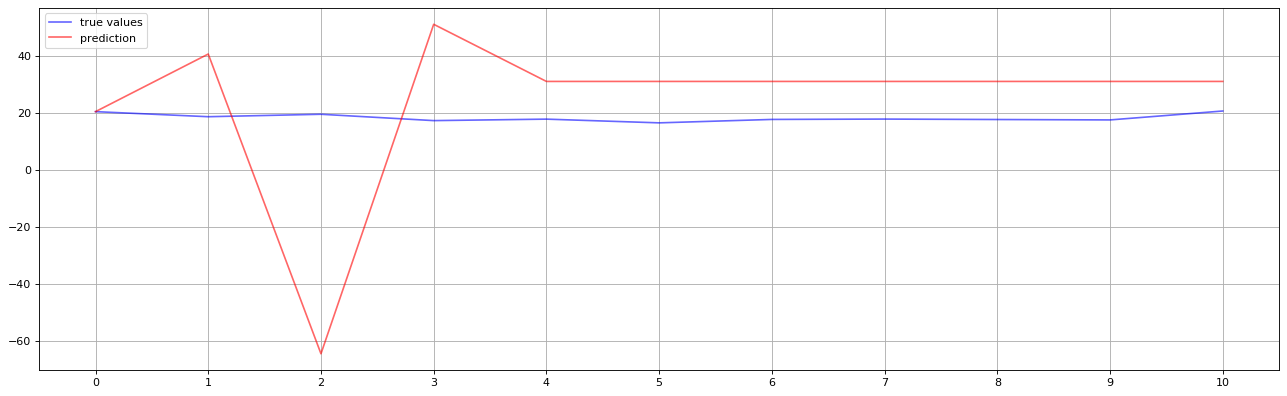

today forcast 2


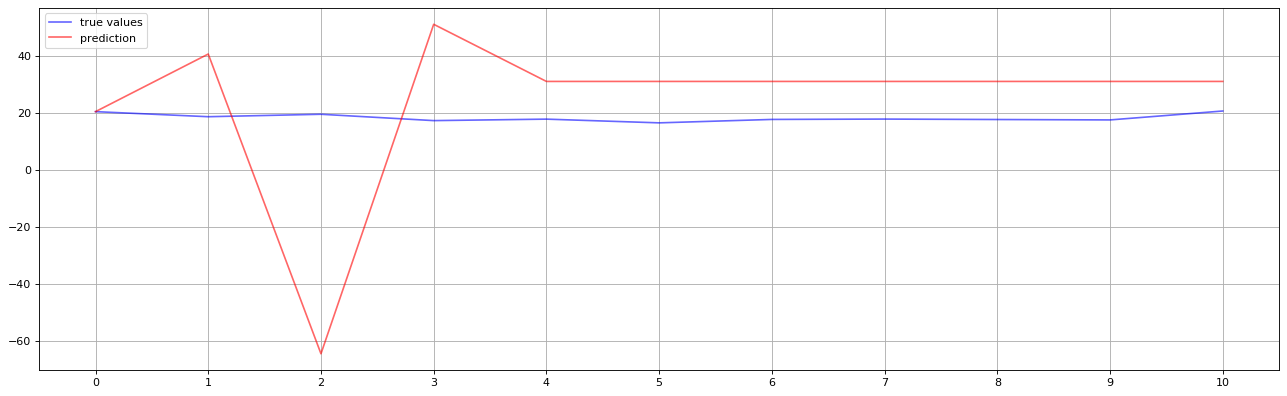

[32.14744041559078, 7.542412035979353, 14.730878458936717, 14.730878458936717, 14.730878458936717, 14.730878458936717, 14.730878458936717, 14.730878458936717, 14.730878458936717, 14.730878458936717]


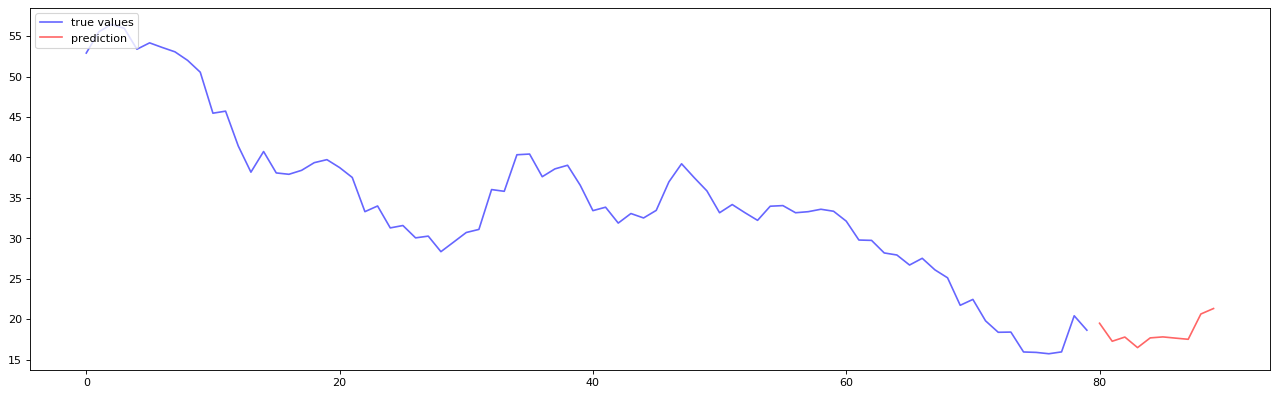

last price:18.6380973513821	next price:19.498243932216248
today forcast 44


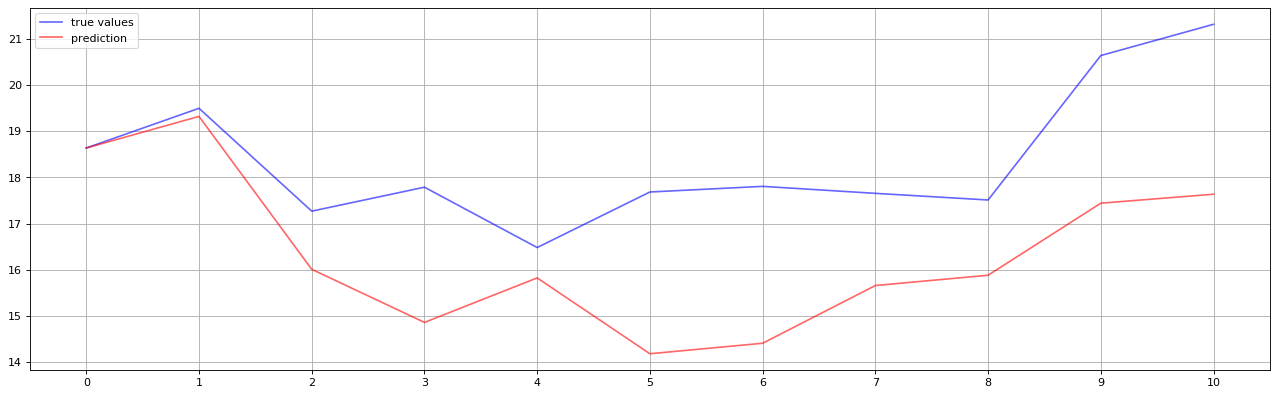

today forcast 2


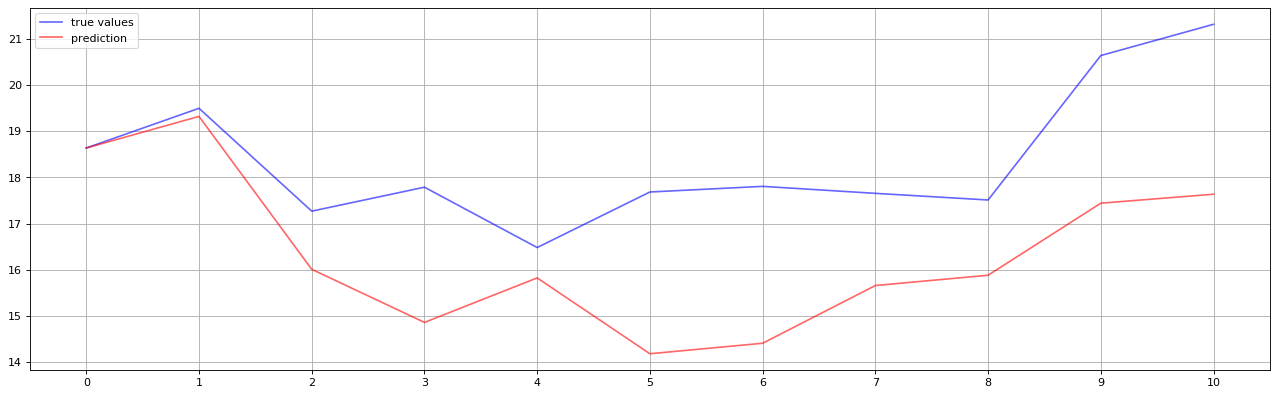

[19.357652973594945, 17.29396274482494, 16.578970659963037, 16.578970659963037, 16.578970659963037, 16.578970659963037, 16.578970659963037, 16.578970659963037, 16.578970659963037, 16.578970659963037]


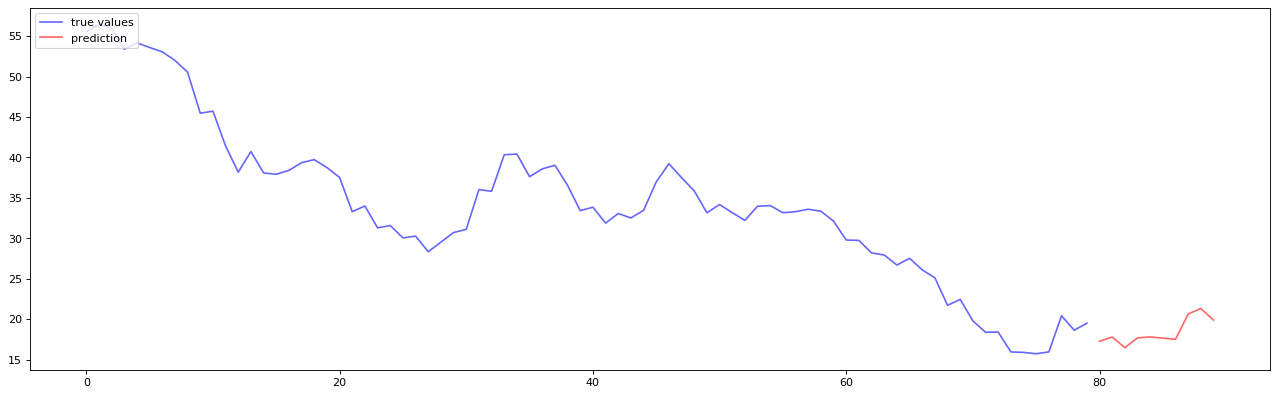

last price:19.498243932216248	next price:17.269888848359443
today forcast 2


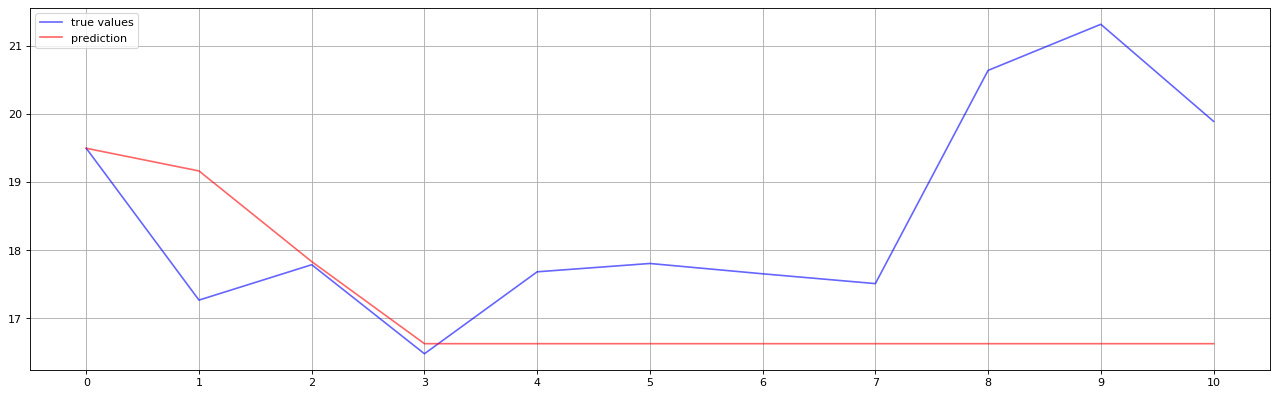

today forcast 2


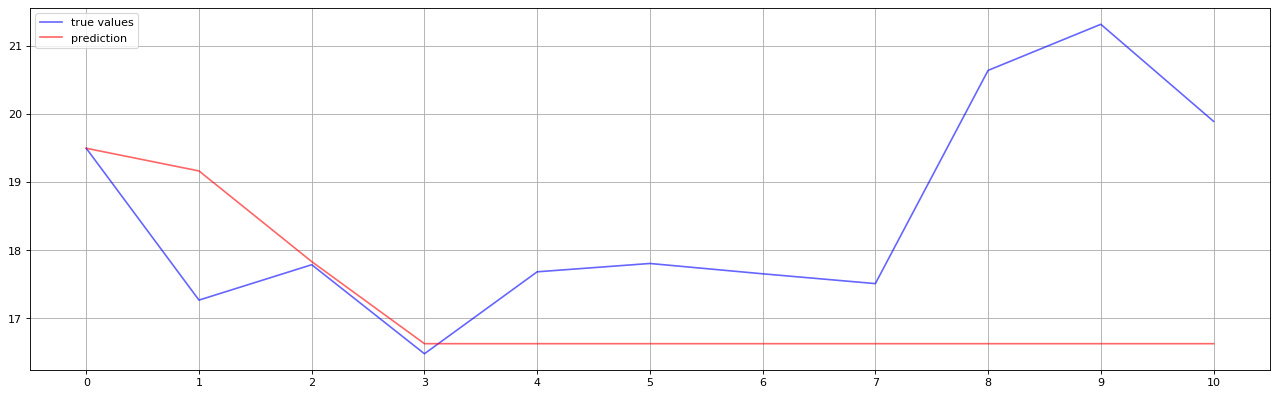

[19.16563568900515, 17.834866558761284, 16.63024558105736, 16.63024558105736, 16.63024558105736, 16.63024558105736, 16.63024558105736, 16.63024558105736, 16.63024558105736, 16.63024558105736]


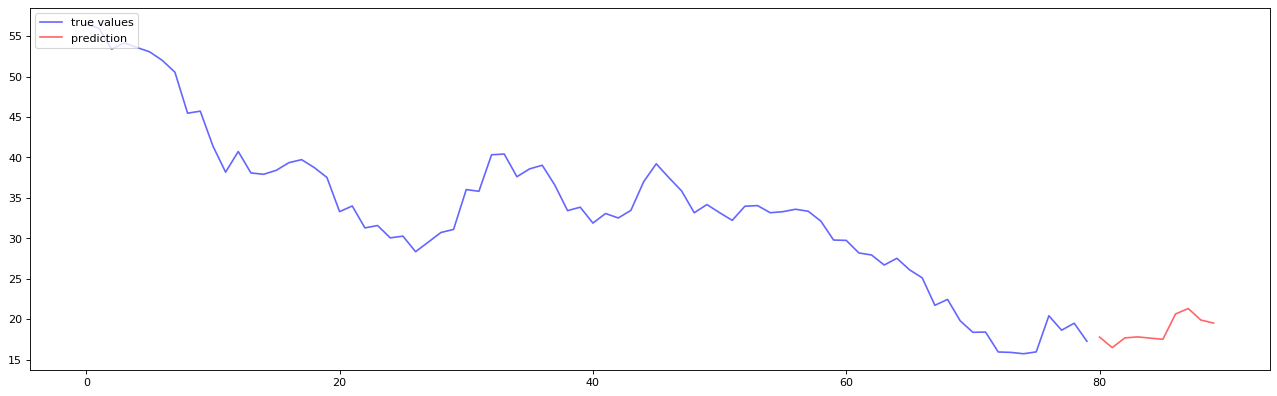

last price:17.269888848359443	next price:17.789195742047028
today forcast 48


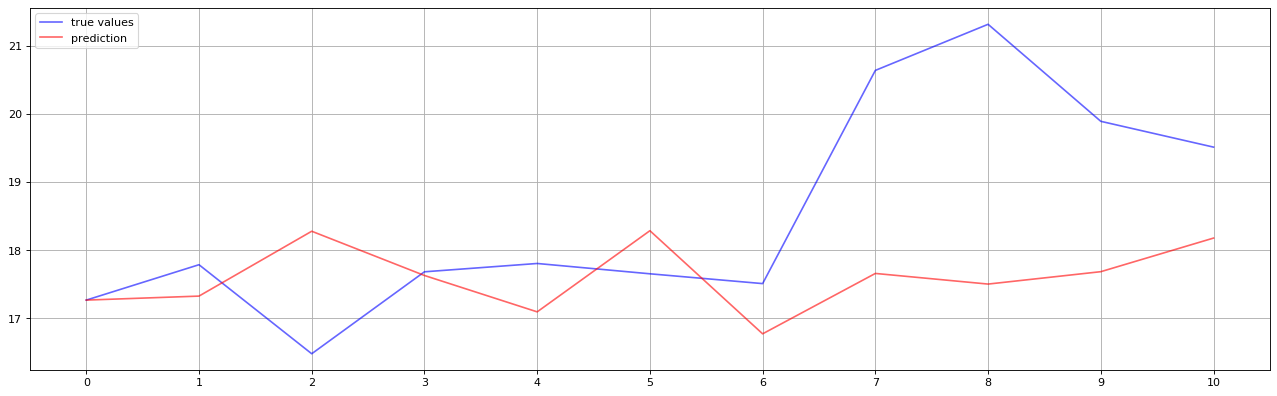

today forcast 2


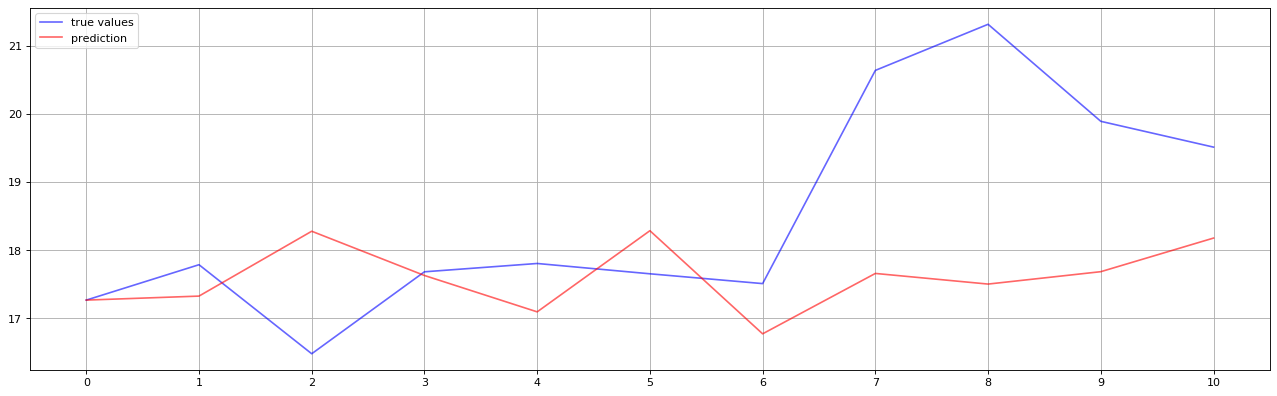

[22.12548630144144, 17.20491494331476, 16.150784167299218, 16.150784167299218, 16.150784167299218, 16.150784167299218, 16.150784167299218, 16.150784167299218, 16.150784167299218, 16.150784167299218]


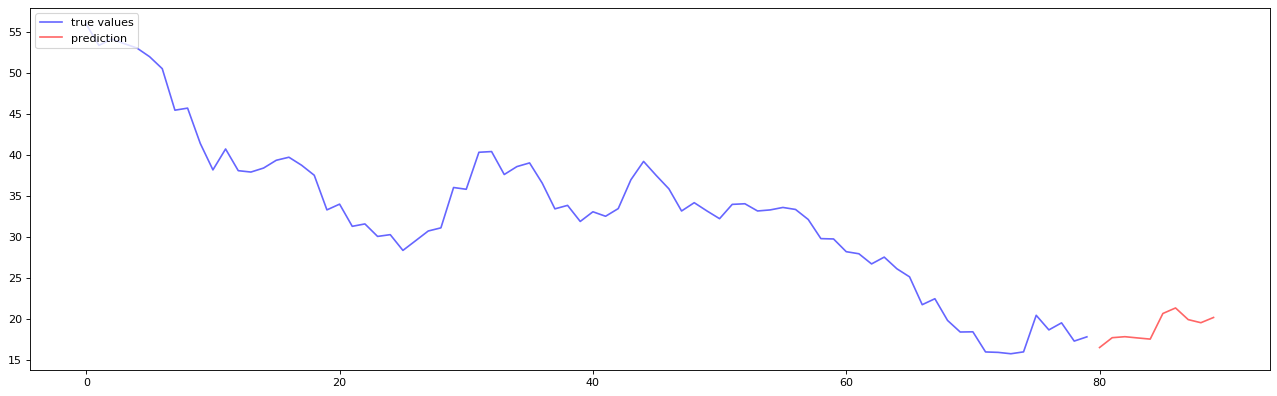

last price:17.789195742047028	next price:16.482517927646086
today forcast 2


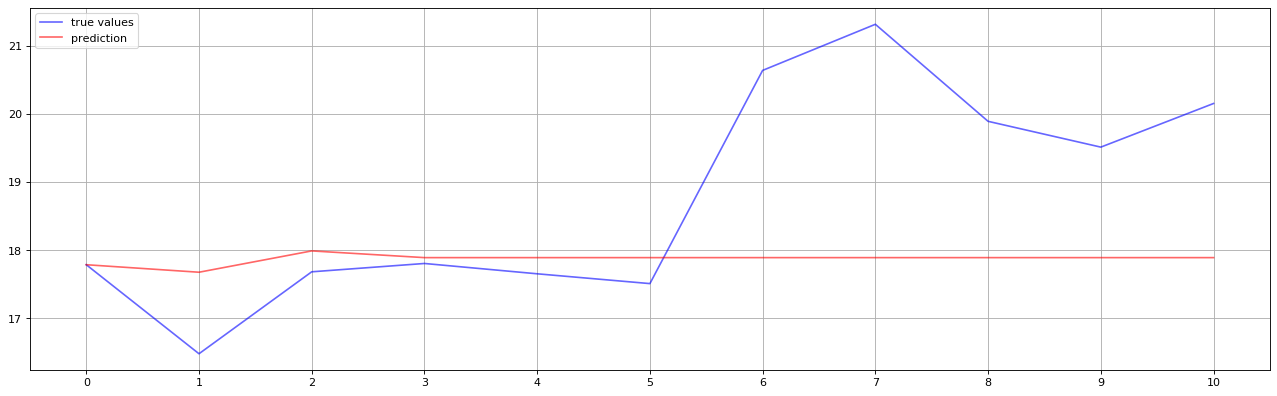

today forcast 2


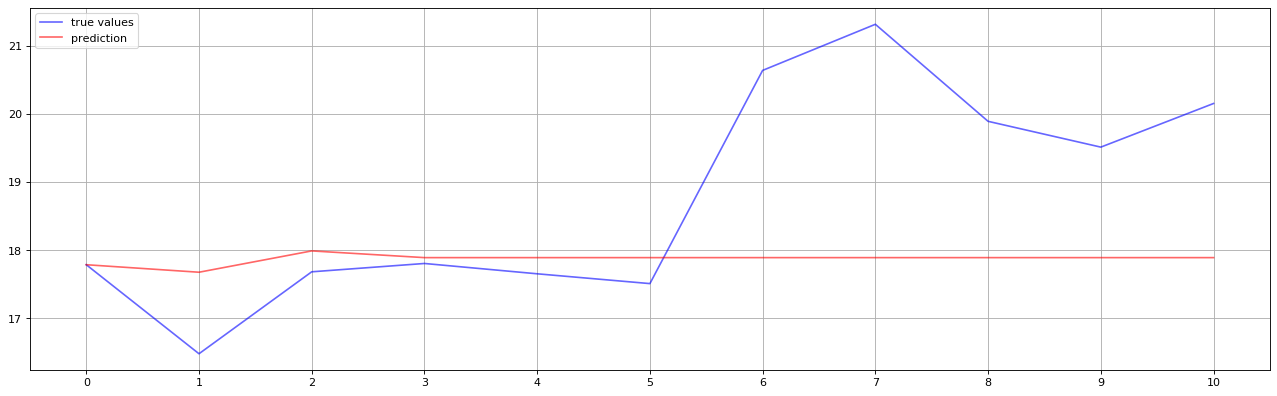

[17.6789595357328, 17.991892039359715, 17.893354150356174, 17.893354150356174, 17.893354150356174, 17.893354150356174, 17.893354150356174, 17.893354150356174, 17.893354150356174, 17.893354150356174]


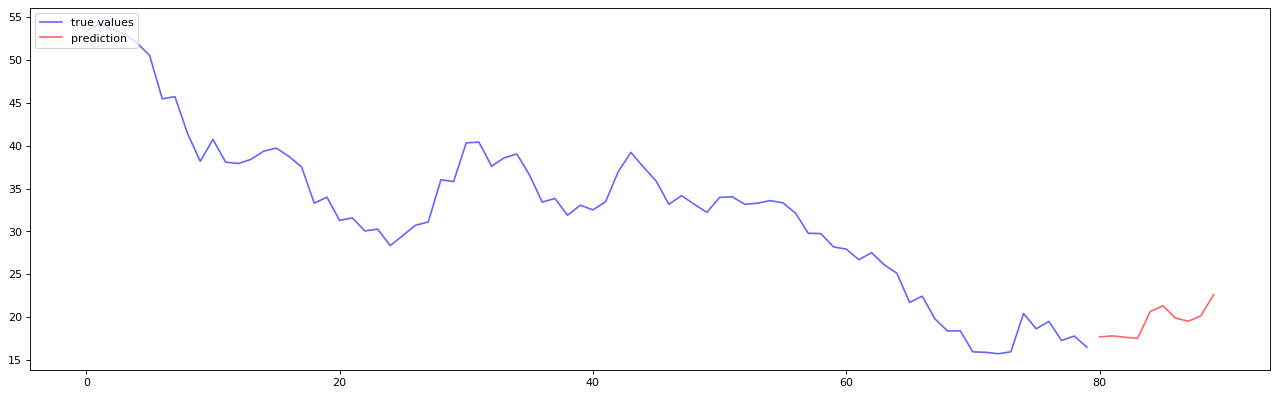

last price:16.482517927646086	next price:17.685238050727275
today forcast 2


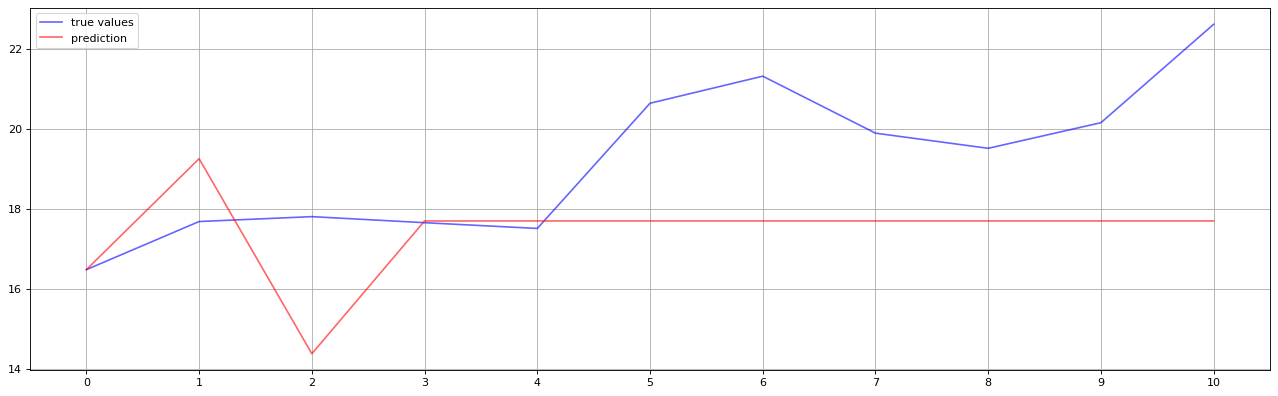

today forcast 2


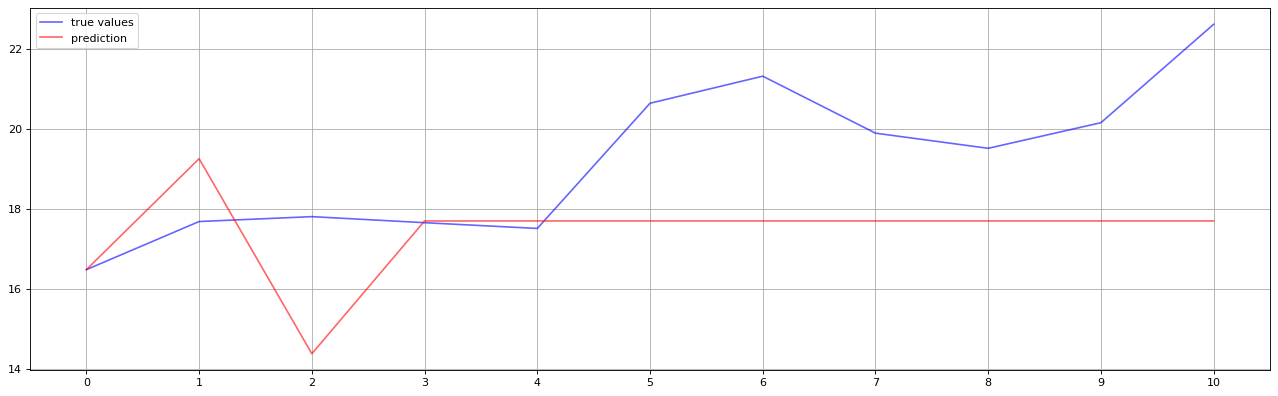

[19.255518351787742, 14.380390075672906, 17.699466338269204, 17.699466338269204, 17.699466338269204, 17.699466338269204, 17.699466338269204, 17.699466338269204, 17.699466338269204, 17.699466338269204]


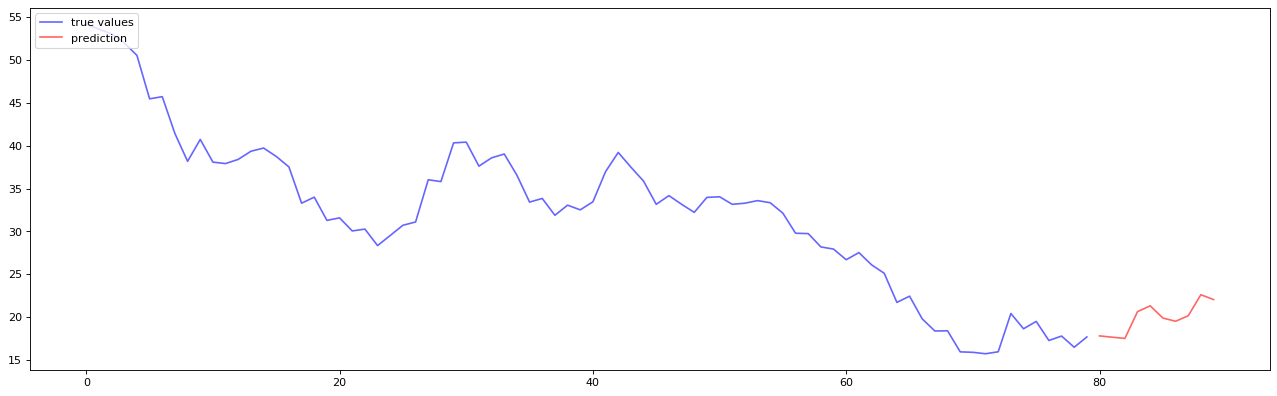

last price:17.685238050727275	next price:17.807414044230736
today forcast 2


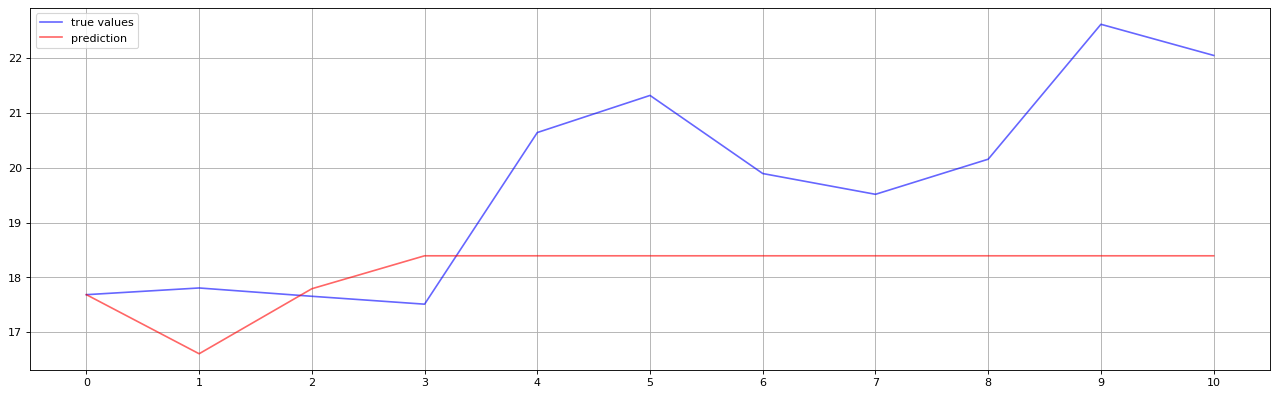

today forcast 2


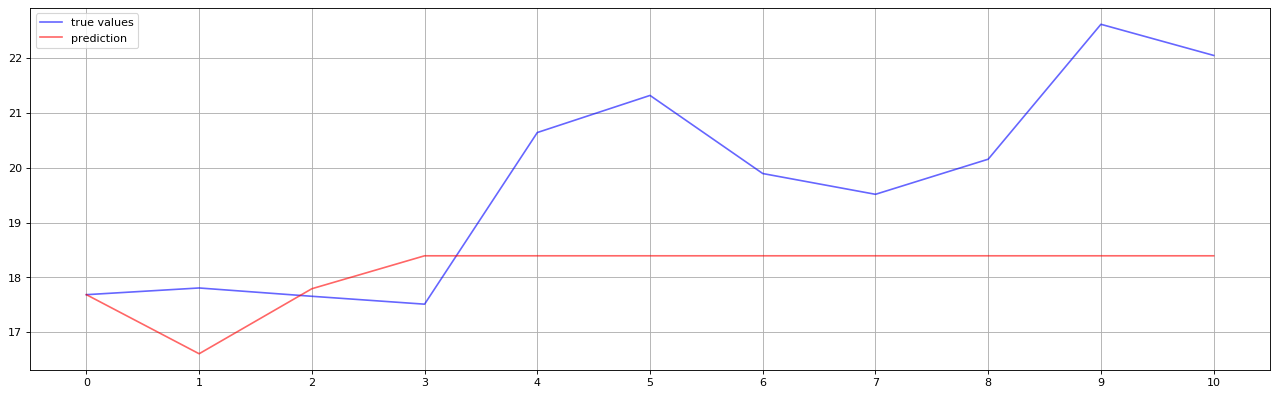

[16.608197445250944, 17.793676087394395, 18.39414739193634, 18.39414739193634, 18.39414739193634, 18.39414739193634, 18.39414739193634, 18.39414739193634, 18.39414739193634, 18.39414739193634]


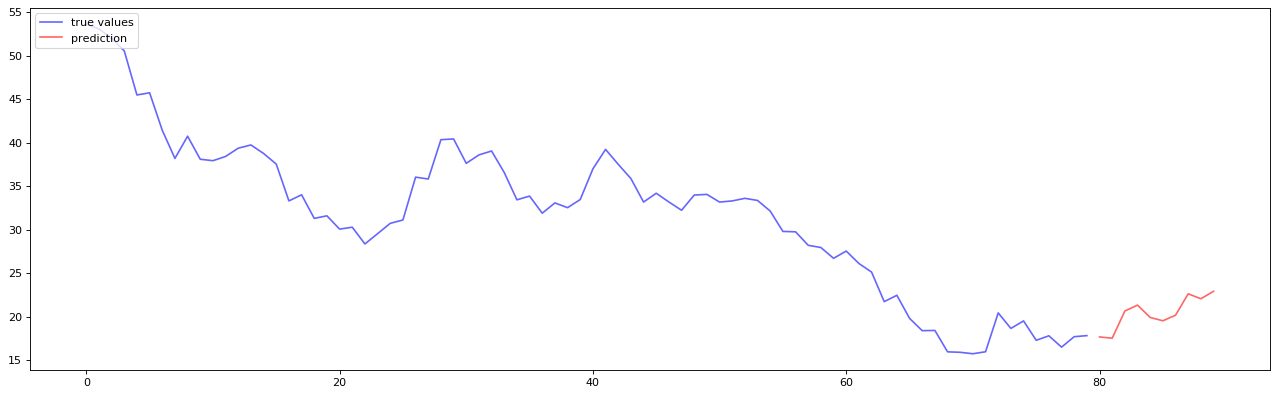

last price:17.807414044230736	next price:17.655945424196553
today forcast 2


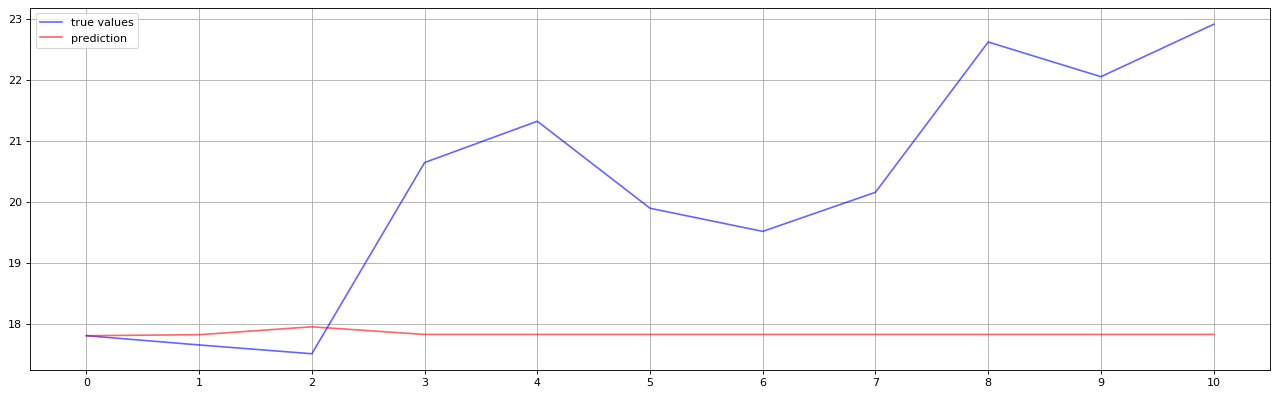

today forcast 2


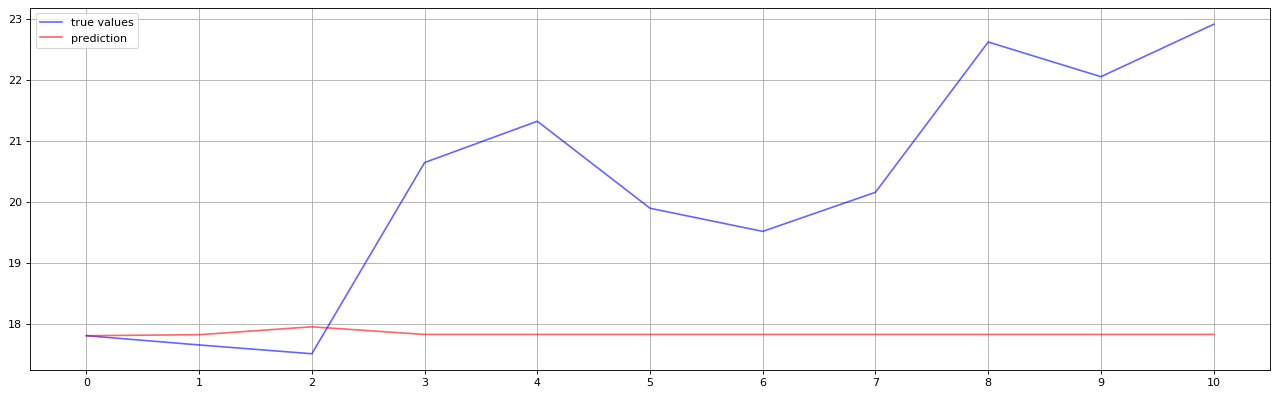

[17.824126632999114, 17.95312192097203, 17.827883147100803, 17.827883147100803, 17.827883147100803, 17.827883147100803, 17.827883147100803, 17.827883147100803, 17.827883147100803, 17.827883147100803]


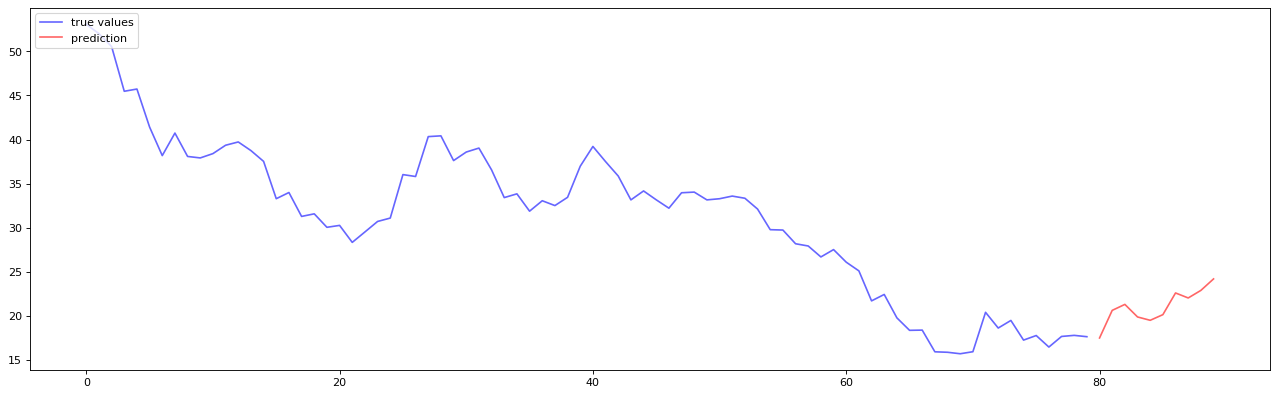

last price:17.655945424196553	next price:17.512077333521905
today forcast 2


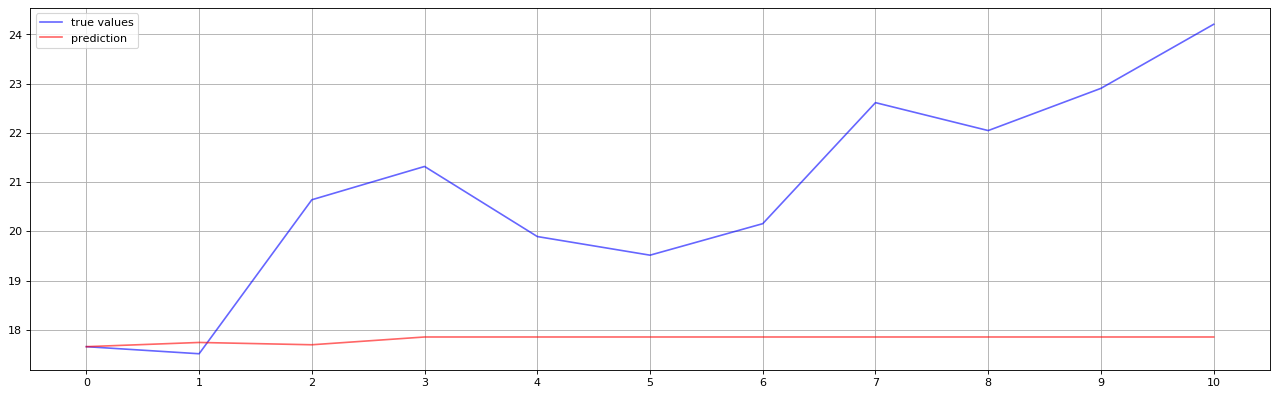

today forcast 2


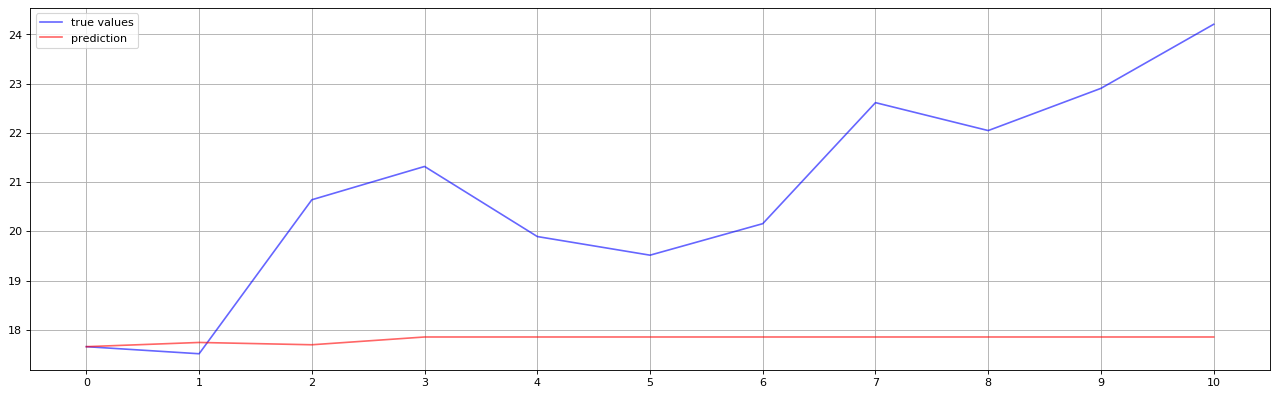

[17.74154553007421, 17.694679557885102, 17.852715586572877, 17.852715586572877, 17.852715586572877, 17.852715586572877, 17.852715586572877, 17.852715586572877, 17.852715586572877, 17.852715586572877]


In [236]:
for i in range(260,280):

    data = temp_data[i:i+80]
    y = temp_data[i+80:i+90]
    data.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    y.index += 80 
    for feature in zero_cleaner_features:
        zero_cleaner(data[feature])
    target_generator(data)                
    grow_label_generator(data)


    plot_trend(data['price'],y['price'])
    print('last price:{}\tnext price:{}'.format(data.tail(1)['price'].values[0],y.head(1)['price'].values[0]))

    today = data.shape[0]-1

    rmse_arr = [0]
    mape_arr = [0]
    opt_n =0
    min_rmse =10000
    for i in range (2,50):
        pred , rmse , mape = multi_reg_model(data , today-10, i,False)
        rmse_arr.append(rmse)
        mape_arr.append(mape)
        if min_rmse > rmse:
            min_rmse = rmse
            opt_n=i
    #     print('N:{}\trmse:{}\tmape:{}'.format(i , rmse,mape))
    # plot_trend(rmse_arr,split_point = opt_n,full_x=True)
    # plot_trend(mape_arr,split_point = opt_n, full_x=True)

    temp_y = y['price'].values
    temp_y = np.insert(temp_y, 0, data.tail(1)['price'].values[0] , axis=0)

    print('today forcast {}'.format(opt_n))
    pred = multi_reg_model(data ,today , opt_n, plot = False,forcast=True)
    temp_pred = np.insert(pred, 0, data.tail(1)['price'].values[0], axis=0)
    plot_trend(temp_y,temp_pred,full_x=True)

    print('today forcast 2')
    pred = multi_reg_model(data ,today , 2, plot = False,forcast=True)
    plot_trend(temp_y,temp_pred,full_x=True)
    print (pred)